## 3) Exploratory data analysis (EDA)

><font color='lightgrey'>GOAL OF THIS SECTION  
    *To provide descriptive statistics and informative plots on the features.  
    To explore relationships amongst the features themselves and with the target.  
    To check for missing values and outliers*  </font>

With this section we try to answer the question: How the features influence our target 'cout_unitaire_pour_la_qte_demandee'?  

To answer this main question we will break it down into several subordinates questions which we list below.  

We will then set a plan to answer those: This plan will include the exploration of relations between features and target with plots, correlations coefficients, to start to quantify what tendering managers observe in the business and what our intuitions says.   

In the next section on machine learning we will quantify fully the relation between our features and target.  

### Project expectation vs. features & target selection

#### Relation between features and target 

We can summarize as follow which source brings which kind of information, although the borders are not so strict:  

- The step source is generally expected to give the complexity of the geometry and the size of the part.
- The pdf source is generally expected to give the complexity of the tolerancing of the part.
- The calculation source is expected to give the process to manufacture the part.  

With those 3 information we expect to have the possibility to predict a target selected as as the total part unit costs, which corresponds to the complete sum of internal and external costs, including all different types of costs sub components; this is optimistic and we will see how far it can work with a given level of information.  

#### Choice of feature selected

- **Source step**: We have completely dropped the step source for the proposal, at time of writing it not enough data received.  

- **Source pdf**: We have almost used 50% of the possible features. The detection of the symbols currently lacks of precision, the detection rate is almost zero on the symbols we target, with the basic google vision API. To get better results and be able to use the features, we would need to train a detection model within google AutoML or home made with Tensorflow to detect the specific technical drawing symbols we want. This seams feasable and realistic, but outside of the Capestone scope for time reasons. Also we decided to first focus on the few symbols detected and see the impact it has on the target within EDA and ML sections.  

- **Source calc**: We used all the features we can, seeing that many of the foreseen fields are not populated by the tender managers. We add below one important comment in relation to this selection:  

#### Feature selected from the calc source  

Our target is the sum of several lines of costs, which we have let in the features list:

INTERNAL COSTS
- cout_methodes
- cout_reglage
- cout_usinage
- cout_controle
- autres_couts


EXTERNAL COSTS
- matiere
- traitements
- peinture
- s_t_meca
- autres_couts


It would be useless to build a model using directly those features to simply add those costs together to predicts a target. What we do instead is the following:  
- We use the information that a data is available under the features 'methodes', 'reglage', 'controle', 'matiere', 'traitements', 's_t_meca', 'autres_couts' to build 2 features:  
  - One which indicates the presence of this element: It is indeed easy and necessary that the tender manager can give the input: on this project we need control and tooling for instance, and accordingly activates the corresponding trigger.
  - One which indicates the expected corresponding order of magnitude (range based on qcut quantiles): Also here the tender manager can easily say: from my experience we need a high/ middle/low provision for tooling. Here, one could say we cheat a little bit. We will see in the ML phase if we still get good score by removing this ordinal input. Eventually we could set the trigger only with low and high instead of low/middle/high.

- We use those specific information as those are not available anywhere through features available from the source 2 and 3. The model will not be able to invent them.

- On the contrary the feature cout_usinage is dropped since this is exactly the one for which we get many information from source 2 and 3, i.e. related to the part geometry and complexity.



#### Alternative selection

We could have decided to be more focused in a first stage and select the target as beeing only the internal costs / usinage portion of the total costs and analyse the effects of the pdf and the step source on this one.  

After all, this part of the costs is a critical parameter we want to be able to predict and with this option we would have got rid of all side effects related to external costs for which we have little level of information.

In this capestone project we decided not to follow this alternative in a first stage, and we tried to predict the complete costs of the part and evaluate the level of precision we could get.  

### Our questions

In this section we summarize the questions on which we want to get insights:   

1. What is the distribution shape of the target ?  
2. What is the distribution shape of the features, where are the outliers in features and target ?  
3. What are the top and lowest drivers for the target within the features space ?  
4. What are the features which seem strongly correlated between each other ? 
5. What do we observe from the feature related to drawings quality ?  
6. What trend do we observe in dimensions and tolerance bands ?  
7. Do we see specific groups or clusters in the target, explained by some features ?  

### Loading & keeping only a subset of features

This first phase aims at loading the prepared data stored locally as a npz file in a local repository called cpst_path='C:/Users/BS/cpstdata'  

- We load dataframe of features  
- We infer datatypes with pd.DataFrame.infer_objects()  
- We remove the columns with threshold (10 requiered non-NA values)  
- We make 3 groups of features for easier manipulation (used_features_calc, used_features_step, used_features_pdf).
- We allow activation of a portion only of those features. The features retained in this preliminary EDA analysis are the ones below, some features have been dropped from the original due to low cardinality of the dataset at the time of writing this proposal:    

We start by setting up the notebook with necessary librairies.

In [1]:
# Import necessary library

import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 150)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

import pandas_profiling
from pandas_profiling import ProfileReport

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import scipy.stats as stats

import warnings
warnings.simplefilter('ignore',
                      category=(FutureWarning,
                                DeprecationWarning,
                                RuntimeWarning))

import os

We also need to retrieve some variables which were stored in memory after running the preceding notebooks used for data retrieval and assembly. We check availability of those variables with the magic command 'whos'.

In [2]:
# Getting stored data back from original notebooks where data is generated
%store -r devis_path
%store -r cpst_path
%store -r step_path
%store -r pdf_path
%store -r calc_path
%store -r git_path

#Checking the variables active in the notebook
%whos

Variable           Type      Data/Info
--------------------------------------
ProfileReport      type      <class 'pandas_profiling.<...>le_report.ProfileReport'>
calc_path          str       C:/Users/BS/cpstdata/calc_data
cpst_path          str       C:/Users/BS/cpstdata
devis_path         str       C:/Users/BS/cpstdata/devis
git_path           str       C:/Users/BS/Documents/EPF<...>020/proposal_data_samples
np                 module    <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
os                 module    <module 'os' from 'C:\\Us<...>\\Capestone\\lib\\os.py'>
pandas_profiling   module    <module 'pandas_profiling<...>_profiling\\__init__.py'>
pd                 module    <module 'pandas' from 'C:<...>es\\pandas\\__init__.py'>
pdf_path           str       C:/Users/BS/cpstdata/pdf_data
plt                module    <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>
sns                module    <module 'seaborn' from 'C<...>s\\seaborn\\__init__.py'>
stats            

As we use this notebook to test several conditions, we often run it during project development and we appreciate having a trigger to desactivate the generation of plots or html profile reports, which are both time consuming. This is what we setup below:

In [3]:
# Setting-up triggers to control the quantity of notebook outputs

profiling_trigger = 1   # Allow profiling reports of the datasets
plotting_trigger = 1   # Allow plots of the datasets

We load the *.npz files generated by the last step of our extraction process and convert it to dataframe.

In [4]:
# Load npz files
with np.load(cpst_path+'/df_merged.npz', allow_pickle=True) as npzfile:
    
    # Load the arrays in a Python dictionary
    merged_data = dict(npzfile.items())
    
    # Append dictionnary to dataframe
    df_merged=pd.DataFrame(merged_data['features'],
                           columns=merged_data['names'])

# Display the dataframe
print(df_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113 entries, 0 to 1112
Columns: 473 entries, nom_du_client to dimension_band_irq
dtypes: object(473)
memory usage: 4.0+ MB
None


We start cleaning this dataframe  with basic inferance of datatype and filtering columns with low level of information.  

In [5]:
# Infer datatype
df_merged=df_merged.infer_objects()
df_merged.info(verbose=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113 entries, 0 to 1112
Columns: 473 entries, nom_du_client to dimension_band_irq
dtypes: float64(326), object(147)
memory usage: 4.0+ MB


In [6]:
# we remove the columns with less than 10 entries 
df_merged.dropna(thresh=10,
                 axis=1,
                 inplace=True)

We display the dataframe head and its basic information. This corresponds to the maximum level of information extracted for this project, at a stage where all features are still included. During the project we will decide to remove some of those.

In [7]:
# We display the dataframe head
df_merged.head(2)

,nom_du_client,reference_client_de_la_piece,designation_client_de_la_piece,quantite_demandee,chiffrage_pour_la_qte_demandee_quantite_unite,chiffrage_pour_la_qte_demandee_pv_unitaire_eurht,chiffrage_pour_la_qte_demandee_tps_de_cycle_semaines,chiffrage_pour_la_qte_demandee_pr_unitaire_eurht,chiffrage_pour_la_qte_demandee_marge_%,chiffrage_2_quantite_unite,chiffrage_2_pv_unitaire_eurht,chiffrage_2_tps_de_cycle_semaines,chiffrage_2_pr_unitaire_eurht,chiffrage_2_marge_%,chiffrage_3_quantite_unite,chiffrage_3_pv_unitaire_eurht,chiffrage_3_tps_de_cycle_semaines,chiffrage_3_pr_unitaire_eurht,chiffrage_3_marge_%,chiffrage_4_quantite_unite,chiffrage_4_pv_unitaire_eurht,chiffrage_4_tps_de_cycle_semaines,chiffrage_4_pr_unitaire_eurht,chiffrage_4_marge_%,chiffrage_5_quantite_unite,chiffrage_5_pv_unitaire_eurht,chiffrage_5_tps_de_cycle_semaines,chiffrage_5_pr_unitaire_eurht,chiffrage_5_marge_%,chiffrage_6_tps_de_cycle_semaines,caracteristiques_piece_dim_matiere_brute_diametre_dia_mm,caracteristiques_piece_dim_matiere_brute_longueur_l_mm,caracteristiques_piece_dim_matiere_brute_largeur_l_mm,caracteristiques_piece_dim_matiere_brute_epaisseur_e_mm,caracteristiques_piece_commentaires_1,caracteristiques_piece_commentaires_2,cout_unitaire_pour_la_qte_demandee,cout_unitaire_interne,cout_unitaire_externe,temps_methodes_h_piece,temps_de_reglage_h_piece,temps_d'usinage_h_piece,temps_de_controle_h_piece,autres_temps_h_piece,cout_methodes_et_outillage_eur_piece,cout_reglage_eur_piece,cout_usinage_eur_piece,cout_controle_eur_piece,autres_couts_internes_eur_piece,matiere_eur_piece,traitements_eur_piece,peinture_eur_piece,s_t_meca_eur_piece,autres_couts_externes_eur_piece,total_matiere_unitaire_hors_machine_eurht,couts_unitiares_matiere_1_hors_machine_eurht,couts_unitiares_matiere_2_hors_machine_eurht,nature_matiere_matiere_1,nature_matiere_matiere_2,nature_matiere_matiere_3,matiere_1_commentaire_devis,matiere_2_commentaire_devis,matiere_3_commentaire_devis,nrc_eurht_methodes_programmation_tps_total_hors_machine,nature_operation_methodes_programmation,nature_operation_outillage,methodes_programmation_commentaire_devis,outillage_commentaire_devis,temps_h_op_1_tps_total_pour_la_qte_demandee_reglage,temps_h_op_1_nature_operation,temps_h_op_1_tps_unitaire_operation,temps_h_op_2_tps_total_pour_la_qte_demandee_reglage,temps_h_op_2_nature_operation,temps_h_op_2_tps_unitaire_operation,temps_h_op_3_tps_total_pour_la_qte_demandee_reglage,temps_h_op_3_nature_operation,temps_h_op_3_tps_unitaire_operation,temps_h_op_4_tps_total_pour_la_qte_demandee_reglage,temps_h_op_4_nature_operation,temps_h_op_4_tps_unitaire_operation,temps_h_op_5_tps_total_pour_la_qte_demandee_reglage,temps_h_op_5_nature_operation,temps_h_op_5_tps_unitaire_operation,temps_h_op_6_tps_total_pour_la_qte_demandee_reglage,temps_h_op_6_nature_operation,temps_h_op_6_tps_unitaire_operation,temps_h_op_7_tps_total_pour_la_qte_demandee_reglage,temps_h_op_7_nature_operation,temps_h_op_7_tps_unitaire_operation,temps_h_controle_tps_unitaire,nature_controle_tps_unitaire,commentaire_controle_tps_unitaire,temps_h_autre_1_a_preciser_tps_unitaire,nature__autre_1_a_preciser_tps_unitaire,commentaire_autre_1_a_preciser_tps_unitaire,temps_h_autre_2_a_preciser_tps_unitaire,nature_autre_2_a_preciser_tps_unitaire,commentaire_autre_2_a_preciser_tps_unitaire,op1_type_debit_decoupe,op1_type_tournage_cn,op1_type_tournage_cn_et_4eme_axe,op1_type_fraisage_conv,op1_type_fraisage_cn_3_axes,op1_type_fraisage_cn_4_axes,op1_type_fraisage_cn_5_axes,op1_type_rectif_plane,op1_type_hors_machine,op1_commentaires_1_sous_traitant_devis,op1_commentaires_2_sous_traitant_devis,op2_type_debit_decoupe,op2_type_tournage_cn,op2_type_tournage_cn_et_4eme_axe,op2_type_fraisage_conv,op2_type_fraisage_cn_3_axes,op2_type_fraisage_cn_4_axes,op2_type_fraisage_cn_5_axes,op2_type_rectif_plane,op2_type_hors_machine,op2_commentaires_1_sous_traitant_devis,op2_commentaires_2_sous_traitant_devis,op3_type_debit_decoupe,op3_type_tournage_cn,op3_type_tournage_cn_et

In [8]:
# We check the dataframe informations
df_merged.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113 entries, 0 to 1112
Data columns (total 452 columns):
 #   Column                                                       Dtype  
---  ------                                                       -----  
 0   nom_du_client                                                object 
 1   reference_client_de_la_piece                                 object 
 2   designation_client_de_la_piece                               object 
 3   quantite_demandee                                            float64
 4   chiffrage_pour_la_qte_demandee_quantite_unite                float64
 5   chiffrage_pour_la_qte_demandee_pv_unitaire_eurht             object 
 6   chiffrage_pour_la_qte_demandee_tps_de_cycle_semaines         object 
 7   chiffrage_pour_la_qte_demandee_pr_unitaire_eurht             float64
 8   chiffrage_pour_la_qte_demandee_marge_%                       float64
 9   chiffrage_2_quantite_unite                                   float64
 10 

We first perform a selection of the features available in our main dataframe, since will not use all of them in our current Capestone project.  

We will see after if we can or if we need to use more of those te be able to build the prediction system with the precision we need. 

In [9]:
# We pre-select features

used_features_calc=[\
                    'file_name_calc',
                    'path_6_calc',
                    #'calc_file',
                    'chiffrage_pour_la_qte_demandee_quantite_unite',
                    #'chiffrage_pour_la_qte_demandee_pr_unitaire_eurht',
                    'cout_unitaire_pour_la_qte_demandee',
                    'cout_unitaire_interne',
                    'cout_unitaire_externe',
                    #'temps_methodes_h_piece',
                    #'temps_de_reglage_h_piece',     
                    #'temps_d\'usinage_h_piece',
                    #'temps_de_controle_h_piece',
                    'cout_methodes_et_outillage_eur_piece',            
                    'cout_reglage_eur_piece',               
                    'cout_usinage_eur_piece',
                    'cout_controle_eur_piece',               
                    'autres_couts_internes_eur_piece',
                    'matiere_eur_piece',              
                    'traitements_eur_piece',               
                    'peinture_eur_piece',            
                    's_t_meca_eur_piece',
                    'autres_couts_externes_eur_piece',               
                    #'total_matiere_unitaire_hors_machine_eurht',               
                    'nature_matiere_matiere_1',
                    #'temps_h_op_1_tps_total_pour_la_qte_demandee_reglage',               
                    'temps_h_op_1_nature_operation',               
                    #'temps_h_op_1_tps_unitaire_operation',
                    #'temps_h_op_2_tps_total_pour_la_qte_demandee_reglage',               
                    'temps_h_op_2_nature_operation',
                    #'temps_h_op_2_tps_unitaire_operation',
                    #'temps_h_op_3_tps_total_pour_la_qte_demandee_reglage',
                    'temps_h_op_3_nature_operation',               
                    #'temps_h_op_3_tps_unitaire_operation',
                    #'temps_h_op_4_tps_total_pour_la_qte_demandee_reglage',
                    'temps_h_op_4_nature_operation',               
                    #'temps_h_op_4_tps_unitaire_operation',               
                    #'temps_h_op_5_tps_total_pour_la_qte_demandee_reglage',
                    'temps_h_op_5_nature_operation',               
                    #'temps_h_op_5_tps_unitaire_operation',               
                    #'temps_h_op_6_tps_total_pour_la_qte_demandee_reglage',
                    'temps_h_op_6_nature_operation',      #         
                    #'temps_h_op_6_tps_unitaire_operation',               
                    #'temps_h_op_7_tps_total_pour_la_qte_demandee_reglage',
                    'temps_h_op_7_nature_operation',      #          
                    #'temps_h_op_7_tps_unitaire_operation',               
                    #'temps_h_controle_tps_unitaire',
                    'op1_type_debit_decoupe',               
                    'op1_type_tournage_cn',               
                    'op1_type_tournage_cn_et_4eme_axe',
                    'op1_type_fraisage_conv',               
                    'op1_type_fraisage_cn_3_axes',               
                    'op1_type_fraisage_cn_4_axes',               
                    'op1_type_fraisage_cn_5_axes',               
                    'op1_type_rectif_plane',      # 
                    'op1_type_hors_machine',               
                    'op2_type_debit_decoupe',      #                
                    'op2_type_tournage_cn',               
                    'op2_type_tournage_cn_et_4eme_axe',
                    'op2_type_fraisage_conv',               
                    'op2_type_fraisage_cn_3_axes',               
                    'op2_type_fraisage_cn_4_axes',               
                    'op2_type_fraisage_cn_5_axes',               
                    'op2_type_rectif_plane',
                    'op2_type_hors_machine',                 
                    'op3_type_debit_decoupe',      #               
                    'op3_type_tournage_cn',               
                    'op3_type_tournage_cn_et_4eme_axe',
                    'op3_type_fraisage_conv',      #              
                    'op3_type_fraisage_cn_3_axes',               
                    'op3_type_fraisage_cn_4_axes',               
                    'op3_type_fraisage_cn_5_axes',      #           
                    'op3_type_rectif_plane',      # 
                    'op3_type_hors_machine',               
                    'op4_type_debit_decoupe',        #              
                    'op4_type_tournage_cn',      #                
                    'op4_type_tournage_cn_et_4eme_axe',      # 
                    'op4_type_fraisage_conv',      #                
                    'op4_type_fraisage_cn_3_axes',      #                
                    'op4_type_fraisage_cn_4_axes',      #                
                    'op4_type_fraisage_cn_5_axes',      #                
                    'op4_type_rectif_plane',      # 
                    'op4_type_hors_machine',      #                
                    'op5_type_debit_decoupe',      #                
                    'op5_type_tournage_cn',      #                
                    'op5_type_tournage_cn_et_4eme_axe',      # 
                    'op5_type_fraisage_conv',      #                
                    'op5_type_fraisage_cn_3_axes',      #                
                    'op5_type_fraisage_cn_4_axes',      #                
                    'op5_type_fraisage_cn_5_axes',      #                
                    'op5_type_rectif_plane',      # 
                    'op5_type_hors_machine',      #                
                    'op6_type_debit_decoupe',      #                
                    'op6_type_tournage_cn',      #                
                    'op6_type_tournage_cn_et_4eme_axe',      # 
                    'op6_type_fraisage_conv',      #                
                    'op6_type_fraisage_cn_3_axes',      #                
                    'op6_type_fraisage_cn_4_axes',      #                
                    'op6_type_fraisage_cn_5_axes',      #                
                    'op6_type_rectif_plane',      # 
                    'op6_type_hors_machine',      #                
                    'op7_type_debit_decoupe',      #                
                    'op7_type_tournage_cn',      #                
                    'op7_type_tournage_cn_et_4eme_axe',      # 
                    'op7_type_fraisage_conv',      #                
                    'op7_type_fraisage_cn_3_axes',      #                
                    'op7_type_fraisage_cn_4_axes',      #                
                    'op7_type_fraisage_cn_5_axes',      #                
                    'op7_type_rectif_plane',      # 
                    'op7_type_hors_machine',      #               
                    #'total_temps_interne_unitaire_h_type_debit_decoupe',      # 
                    #'total_temps_interne_unitaire_h_type_fraisage_conv',      # 
                    #'total_temps_interne_unitaire_h_type_fraisage_cn_4_axes',      # 
                    #'total_temps_interne_unitaire_h_type_rectif_plane',      # 
                    #'total_temps_interne_unitaire_h_type_hors_machine',      # 
                    'nature_traitement_s_t_mecanique_1',
                    'nature_traitement_s_t_mecanique_2',
                    'nature_traitement_s_t_mecanique_3',
                    'nature_traitement_s_t_traitement_1',
                    'nature_traitement_s_t_traitement_2',
                    'nature_traitement_s_t_traitement_3',
                    #'total_couts_externes_unitaires_eurht' 
                    ]

used_features_step=[\
                    'file_name_step',
                   ]
                    #'chiffrage_pour_la_qte_demandee_quantite_unite',
                    #'chiffrage_pour_la_qte_demandee_pr_unitaire_eurht',
                    #'cout_unitaire_pour_la_qte_demandee',
                    #'total_couts_externes_unitaires_eurht',
                    #'file_name_calc']


used_features_pdf=[\
                    #'tolerance_band',
                    #'dimension_band',
                    #'band_integers_only_warn',
                    #'band_outliers_detected',
                    #'band_outliers',
                    #'has_digit',
                    #'⏤',
                    #'⏥',
                    #'○',
                    #'⌭',
                    #'⌒',
                    #'⌓',
                    #'⟂',
                    #'∠',
                    #'∥',
                    #'⌯',
                    #'⌖',
                    #'◎',
                    #'↗',
                    #'⌰',
                    #'Ⓕ',
                    #'Ⓛ',
                    #'Ⓜ',
                    #'Ⓟ',
                    #'Ⓢ',
                    #'Ⓣ',
                    #'Ⓤ',
                    #'iso2768',
                    #'tol_class',
                    #'holes',
                    #'shafts',
                    '±',
                    #'ref',
                    #'⬜',
                    'Ra',
                    #'N',
                    'Ø',
                    #'°',
                    #'radius',
                    #'unit_inch',
                    #'date',
                    #'invalid_float',
                    #'pdf_page',
                    #'pdf_pages',
                    #'im0_stats',
                    #'path_0',
                    #'path_1',
                    #'path_2',
                    #'path_3',
                    #'path_4',
                    #'path_5',
                    #'path_6',
                    #'path_7',
                    #'path_8',
                    #'path_9',
                    #'path_10_pdf',
                    'file_name',
                    #'pdf_file',
                    'tolerance_band_count',
                    'dimension_band_count',
                    'tolerance_band_min',
                    'tolerance_band_max',
                    'tolerance_band_mean',
                    'tolerance_band_std',
                    'tolerance_band_median',
                    'tolerance_band_quantile_20',
                    'tolerance_band_quantile_80',
                    'tolerance_band_irq',
                    'dimension_band_min',
                    'dimension_band_max',
                    'dimension_band_mean',
                    'dimension_band_std',
                    'dimension_band_median',
                    'dimension_band_quantile_20',
                    'dimension_band_quantile_80',
                    'dimension_band_irq',
                    'quality_indicator_kurtosis',
                    'quality_indicator_skewness',
                    'quality_indicator_variance',
                    'quality_indicator_mean']


used_features = used_features_calc\
                +used_features_step\
                +used_features_pdf

Finally we store our variables and display their list to be able to start the EDA phase

In [10]:
# Store these variable for usage in other notebooks
%store df_merged
%store used_features_calc
%store used_features_step
%store used_features_pdf
%store used_features

#Checking the variables active in the notebook
%whos

Stored 'df_merged' (DataFrame)
Stored 'used_features_calc' (list)
Stored 'used_features_step' (list)
Stored 'used_features_pdf' (list)
Stored 'used_features' (list)
Variable             Type         Data/Info
-------------------------------------------
ProfileReport        type         <class 'pandas_profiling.<...>le_report.ProfileReport'>
calc_path            str          C:/Users/BS/cpstdata/calc_data
cpst_path            str          C:/Users/BS/cpstdata
devis_path           str          C:/Users/BS/cpstdata/devis
df_merged            DataFrame            nom_du_client ref<...>[1113 rows x 452 columns]
git_path             str          C:/Users/BS/Documents/EPF<...>020/proposal_data_samples
merged_data          dict         n=2
np                   module       <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
npzfile              NpzFile      <numpy.lib.npyio.NpzFile <...>ct at 0x000001F545A5D490>
os                   module       <module 'os' from 'C:\\Us<...>\\Capestone\\l

In [11]:
# Display of the features used from calc:
%store -r used_features_calc
display(used_features_calc)

['file_name_calc',
 'path_6_calc',
 'chiffrage_pour_la_qte_demandee_quantite_unite',
 'cout_unitaire_pour_la_qte_demandee',
 'cout_unitaire_interne',
 'cout_unitaire_externe',
 'cout_methodes_et_outillage_eur_piece',
 'cout_reglage_eur_piece',
 'cout_usinage_eur_piece',
 'cout_controle_eur_piece',
 'autres_couts_internes_eur_piece',
 'matiere_eur_piece',
 'traitements_eur_piece',
 'peinture_eur_piece',
 's_t_meca_eur_piece',
 'autres_couts_externes_eur_piece',
 'nature_matiere_matiere_1',
 'temps_h_op_1_nature_operation',
 'temps_h_op_2_nature_operation',
 'temps_h_op_3_nature_operation',
 'temps_h_op_4_nature_operation',
 'temps_h_op_5_nature_operation',
 'temps_h_op_6_nature_operation',
 'temps_h_op_7_nature_operation',
 'op1_type_debit_decoupe',
 'op1_type_tournage_cn',
 'op1_type_tournage_cn_et_4eme_axe',
 'op1_type_fraisage_conv',
 'op1_type_fraisage_cn_3_axes',
 'op1_type_fraisage_cn_4_axes',
 'op1_type_fraisage_cn_5_axes',
 'op1_type_rectif_plane',
 'op1_type_hors_machine',
 'op

In [12]:
# Display of the features used from pdf:
%store -r used_features_pdf
display(used_features_pdf)

['±',
 'Ra',
 'Ø',
 'file_name',
 'tolerance_band_count',
 'dimension_band_count',
 'tolerance_band_min',
 'tolerance_band_max',
 'tolerance_band_mean',
 'tolerance_band_std',
 'tolerance_band_median',
 'tolerance_band_quantile_20',
 'tolerance_band_quantile_80',
 'tolerance_band_irq',
 'dimension_band_min',
 'dimension_band_max',
 'dimension_band_mean',
 'dimension_band_std',
 'dimension_band_median',
 'dimension_band_quantile_20',
 'dimension_band_quantile_80',
 'dimension_band_irq',
 'quality_indicator_kurtosis',
 'quality_indicator_skewness',
 'quality_indicator_variance',
 'quality_indicator_mean']

In [13]:
# Display of the features used from step:
%store -r used_features_step
display(used_features_step)

['file_name_step']

In [14]:
# Display of the features used overall:
%store -r used_features
display(used_features)

['file_name_calc',
 'path_6_calc',
 'chiffrage_pour_la_qte_demandee_quantite_unite',
 'cout_unitaire_pour_la_qte_demandee',
 'cout_unitaire_interne',
 'cout_unitaire_externe',
 'cout_methodes_et_outillage_eur_piece',
 'cout_reglage_eur_piece',
 'cout_usinage_eur_piece',
 'cout_controle_eur_piece',
 'autres_couts_internes_eur_piece',
 'matiere_eur_piece',
 'traitements_eur_piece',
 'peinture_eur_piece',
 's_t_meca_eur_piece',
 'autres_couts_externes_eur_piece',
 'nature_matiere_matiere_1',
 'temps_h_op_1_nature_operation',
 'temps_h_op_2_nature_operation',
 'temps_h_op_3_nature_operation',
 'temps_h_op_4_nature_operation',
 'temps_h_op_5_nature_operation',
 'temps_h_op_6_nature_operation',
 'temps_h_op_7_nature_operation',
 'op1_type_debit_decoupe',
 'op1_type_tournage_cn',
 'op1_type_tournage_cn_et_4eme_axe',
 'op1_type_fraisage_conv',
 'op1_type_fraisage_cn_3_axes',
 'op1_type_fraisage_cn_4_axes',
 'op1_type_fraisage_cn_5_axes',
 'op1_type_rectif_plane',
 'op1_type_hors_machine',
 'op

In [15]:
# Display dataframe head
%store -r df_merged
df_merged[used_features].head(10)

,file_name_calc,path_6_calc,chiffrage_pour_la_qte_demandee_quantite_unite,cout_unitaire_pour_la_qte_demandee,cout_unitaire_interne,cout_unitaire_externe,cout_methodes_et_outillage_eur_piece,cout_reglage_eur_piece,cout_usinage_eur_piece,cout_controle_eur_piece,autres_couts_internes_eur_piece,matiere_eur_piece,traitements_eur_piece,peinture_eur_piece,s_t_meca_eur_piece,autres_couts_externes_eur_piece,nature_matiere_matiere_1,temps_h_op_1_nature_operation,temps_h_op_2_nature_operation,temps_h_op_3_nature_operation,temps_h_op_4_nature_operation,temps_h_op_5_nature_operation,temps_h_op_6_nature_operation,temps_h_op_7_nature_operation,op1_type_debit_decoupe,op1_type_tournage_cn,op1_type_tournage_cn_et_4eme_axe,op1_type_fraisage_conv,op1_type_fraisage_cn_3_axes,op1_type_fraisage_cn_4_axes,op1_type_fraisage_cn_5_axes,op1_type_rectif_plane,op1_type_hors_machine,op2_type_debit_decoupe,op2_type_tournage_cn,op2_type_tournage_cn_et_4eme_axe,op2_type_fraisage_conv,op2_type_fraisage_cn_3_axes,op2_type_fraisage_cn_4_axes,op2_type_fraisage_cn_5_axes,op2_type_rectif_plane,op2_type_hors_machine,op3_type_debit_decoupe,op3_type_tournage_cn,op3_type_tournage_cn_et_4eme_axe,op3_type_fraisage_conv,op3_type_fraisage_cn_3_axes,op3_type_fraisage_cn_4_axes,op3_type_fraisage_cn_5_axes,op3_type_rectif_plane,op3_type_hors_machine,op4_type_debit_decoupe,op4_type_tournage_cn,op4_type_tournage_cn_et_4eme_axe,op4_type_fraisage_conv,op4_type_fraisage_cn_3_axes,op4_type_fraisage_cn_4_axes,op4_type_fraisage_cn_5_axes,op4_type_rectif_plane,op4_type_hors_machine,op5_type_debit_decoupe,op5_type_tournage_cn,op5_type_tournage_cn_et_4eme_axe,op5_type_fraisage_conv,op5_type_fraisage_cn_3_axes,op5_type_fraisage_cn_4_axes,op5_type_fraisage_cn_5_axes,op5_type_rectif_plane,op5_type_hors_machine,op6_type_debit_decoupe,op6_type_tournage_cn,op6_type_tournage_cn_et_4eme_axe,op6_type_fraisage_conv,op6_type_fraisage_cn_3_axes,op6_type_fraisage_cn_4_axes,op6_type_fraisage_cn_5_axes,op6_type_rectif_plane,op6_type_hors_machine,op7_type_debit_decoupe,op7_type_tournage_cn,op7_type_tournage_cn_et_4eme_axe,op7_type_fraisage_conv,op7_type_fraisage_cn_3_axes,op7_type_fraisage_cn_4_axes,op7_type_fraisage_cn_5_axes,op7_type_rectif_plane,op7_type_hors_machine,nature_traitement_s_t_mecanique_1,nature_traitement_s_t_mecanique_2,nature_traitement_s_t_mecanique_3,nature_traitement_s_t_traitement_1,nature_traitement_s_t_traitement_2,nature_traitement_s_t_traitement_3,file_name_step,±,Ra,Ø,file_name,tolerance_band_count,dimension_band_count,tolerance_band_min,tolerance_band_max,tolerance_band_mean,tolerance_band_std,tolerance_band_median,tolerance_band_quantile_20,tolerance_band_quantile_80,tolerance_band_irq,dimension_band_min,dimension_band_max,dimension_band_mean,dimension_band_std,dimension_band_median,dimension_band_quantile_20,dimension_band_quantile_80,dimension_band_irq,quality_indicator_kurtosis,quality_indicator_skewness,quality_indicator_variance,quality_indicator_mean
0,boitier0001301.xlsx,c0000020amplitude,2.0,5629.000000,4323.000000,1306.0,1320.0,198.000000,2409.00,396.00,0.0,710.0,266,0,0,330,nan,Usinage,Ajustage,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan,NICKEL,nan,nan,00013101a01.step,183.0,2.0,25.0,00013101pdf.pdf,11.0,1205.0,0.05,0.800,0.300000,0.251360,0.100,0.100,0.500,0.400,1.6,595.0,73.996432,117.605029,29.0,6.0,94.2,66.00,16.356635,-4.205464,2540.318864,242.804409
1,0320395a0001supportracleurqte2.xlsx,c0000002decoufle,2.0,578.500000,578.500000,0.0,1.0,165.000000,363.00,49.50,0.0,0.0,0,0,0,0,Fonderie Client,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [16]:
# Profiling input data before cleaning

if profiling_trigger == 1:
    
    dftemp=df_merged[used_features].copy()
    
    original_profile=dftemp.profile_report(title='Report before cleaning',
                                           minimal=True,
                                           explorative=False)
    
    original_profile.to_file(cpst_path+'/original_profile.html')

Summarize dataset:   0%|          | 0/128 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Figure size 216x162 with 0 Axes>

### Cleaning steps

Those steps are done on the given dataset with given cardinality at time of project execution, this can be adapted in the future in particular if we receive more data for the same sources 1 and 2 leading the categories to be better or differently populated, or if we receive data from the third step source.

We perform cleaning on our different type of data:
- For categorical ordinal features
- For categorical nominal features
- For quantitative discrete features
- For quantitative continuous features

As explained above, we start our analysis by loading the 'used_features' only and we create a new dataframe 'df_merged_used' as a copy of our original 'df_merged' corresponding to this subset.  

We also include the possibility to generate an meaningful index based on the data, and not only a number (currently this option is not activated).  

In [ ]:
# Preliminary cleaning steps

# Keep only a subset of features
df_merged_used=df_merged[used_features].copy()

# Drop duplicated rows
df_merged_used.drop_duplicates(inplace=True)

# Set a unique index
#df_merged_used['project_index']=df_merged_used['file_name_calc']\
#                         +' _ '+df_merged_used['file_name_step'].fillna('na')\
#                         +' _ '+df_merged_used['file_name'].fillna('na')

df_merged_used.drop(['file_name_step'], axis=1, inplace=True)
#df_merged_used[df_merged_used.duplicated()==True]
#df_merged_used.set_index('project_index',
#                         inplace=True,verify_integrity=False,append=False)
#df_merged_used[df_merged_used.index.duplicated()==True]
## Drop duplicated rows
#df_merged_used.drop_duplicates(inplace=True)
#df_merged_used[df_merged_used.index.duplicated()==True]

In [ ]:
df_merged_used.head() #[df_merged_used.index==781]

We drop rows with missing values, with specifying a threshold, to keep rows with 60% non na in each category (with this we remove rows where a complete block of information is missing for instance the complete pdf data).

In [ ]:
# Drop rows with missing values with a given threshold to keep rows
# with 60% non na in each category

df_merged_used.dropna(inplace=True,
                      axis=0,
                      thresh=np.floor(0.6*len(used_features_pdf)),
                      subset=used_features_pdf)

df_merged_used.dropna(inplace=True,
                      axis=0,
                      thresh=np.floor(0.6*len(used_features_calc)),
                      subset=used_features_calc)

We drop rows with no target value (some excel files were containing no value which make the line useless for prediction)  

In [ ]:
# Drop rows with no target value

df_merged_used.drop(\
        df_merged_used[df_merged_used['cout_unitaire_pour_la_qte_demandee']==0].index,
        axis=0, inplace=True)

df_merged_used.drop(\
        df_merged_used[df_merged_used['cout_unitaire_pour_la_qte_demandee'].isna()].index,
        axis=0, inplace=True)

We encode the client source, as we realize some different clients may have different format of pdf data or different patterns leading to different conditions. We want to be able to inform the machine learning model on this effect.  

In [ ]:
# Encode rows corresponding to specific clients

clients = df_merged_used['path_6_calc']\
                .copy()\
                .value_counts()\
                .index\
                .tolist()

clients_list = clients[6:]

df_merged_used.loc[df_merged_used['path_6_calc'].isin(clients_list),
                   'path_6_calc']='other'

# One-hot encoding of the nominal columns

df_merged_used = pd.get_dummies(df_merged_used,
                                columns=['path_6_calc'],
                                dummy_na=False,
                                drop_first=False)

# Setting datatype to int

for c in [i for i in list(df_merged_used.columns) if 'path_6_calc' in i]:
    df_merged_used[c]=df_merged_used[c].astype(int)

We also correct wrongly inferred datatype for specific categories of features: We set the type to 'int' ans 'str' on purpose for 2 different types of features to allow their manipulation later in the cleaning process.  

In [ ]:
# Correct a wrongly inferred datatype at time of npz file reading

for c in [i for i in used_features if '_type_' in i]:
    df_merged_used[c]=df_merged_used[c].astype(np.int32)

for c in [i for i in used_features if 'nature_' in i]:
    df_merged_used[c]=df_merged_used[c].astype('str')

We detected anomalies in the excel source with complete missing costs blocks leading to na values and we remove those.  

In [ ]:
# Remove rows with missing costs blocks

df_merged_used.drop(\
        df_merged_used[df_merged_used['cout_unitaire_interne'].isna()].index,
        axis=0, inplace=True)

df_merged_used.drop(\
        df_merged_used[df_merged_used['cout_unitaire_externe'].isna()].index,
        axis=0, inplace=True)

We also detected other anomalies in the excel source with unexpected information in certain cells leading to na values and we remove those.  

In [ ]:
# Replace some local errors by nan and fill the missing value by 0

df_merged_used['traitements_eur_piece']=\
                pd.to_numeric(df_merged_used['traitements_eur_piece'],
                              errors = 'coerce')
df_merged_used['traitements_eur_piece'].fillna(value=0, inplace=True)

df_merged_used['s_t_meca_eur_piece']=\
                pd.to_numeric(df_merged_used['s_t_meca_eur_piece'],
                              errors = 'coerce')
df_merged_used['s_t_meca_eur_piece'].fillna(value=0, inplace=True)

df_merged_used['peinture_eur_piece']=\
                pd.to_numeric(df_merged_used['peinture_eur_piece'],
                              errors = 'coerce')
df_merged_used['peinture_eur_piece'].fillna(value=0, inplace=True)

df_merged_used['autres_couts_externes_eur_piece']=\
                pd.to_numeric(df_merged_used['autres_couts_externes_eur_piece'],
                              errors = 'coerce')
df_merged_used['autres_couts_externes_eur_piece'].fillna(value=0, inplace=True)

We decide to delete some outliers already at this stage, although the main outliers removal part is dealt with later on in a specific dedicated chapter.    

In [ ]:
# Delete some outliers
# (preliminary set. further outliers removal done in revelant section)

df_merged_used.drop(\
        df_merged_used[df_merged_used['autres_couts_externes_eur_piece']>10]\
                    .index,
                    axis=0,
                    inplace=True)

df_merged_used.drop(\
        df_merged_used[df_merged_used['peinture_eur_piece']>10]\
                    .index,
                    axis=0,
                    inplace=True)

In order to get ready for the outliers removal we set some indicators giving more light on the different costs subcomponents included in the project.    

In [ ]:
# Compute cost sub-components % of values target for use in outliers detection

df_merged_used['ratio_interne']=\
                        df_merged_used['cout_unitaire_interne']\
                        /df_merged_used['cout_unitaire_pour_la_qte_demandee']

df_merged_used['ratio_externe']=\
                        df_merged_used['cout_unitaire_externe']\
                        /df_merged_used['cout_unitaire_pour_la_qte_demandee']

df_merged_used['ratio_outils']=\
                        df_merged_used['cout_methodes_et_outillage_eur_piece']\
                        /df_merged_used['cout_unitaire_pour_la_qte_demandee']

df_merged_used['ratio_reglage']=\
                        df_merged_used['cout_reglage_eur_piece']\
                        /df_merged_used['cout_unitaire_pour_la_qte_demandee']

df_merged_used['ratio_controle']=\
                        df_merged_used['cout_controle_eur_piece']\
                        /df_merged_used['cout_unitaire_pour_la_qte_demandee']

df_merged_used['ratio_usinage']=\
                        df_merged_used['cout_usinage_eur_piece']\
                        /df_merged_used['cout_unitaire_pour_la_qte_demandee']

df_merged_used['ratio_autres_internes']=\
                        df_merged_used['autres_couts_internes_eur_piece']\
                        /df_merged_used['cout_unitaire_pour_la_qte_demandee']

df_merged_used['ratio_matiere']=\
                        df_merged_used['matiere_eur_piece']\
                        /df_merged_used['cout_unitaire_pour_la_qte_demandee']

df_merged_used['ratio_traitements']=\
                        df_merged_used['traitements_eur_piece']\
                        /df_merged_used['cout_unitaire_pour_la_qte_demandee']

df_merged_used['ratio_meca']=\
                        df_merged_used['s_t_meca_eur_piece']\
                        /df_merged_used['cout_unitaire_pour_la_qte_demandee']

df_merged_used['ratio_peinture']=\
                        df_merged_used['peinture_eur_piece']\
                        /df_merged_used['cout_unitaire_pour_la_qte_demandee']

df_merged_used['ratio_autres_externes']=\
                        df_merged_used['autres_couts_externes_eur_piece']\
                        /df_merged_used['cout_unitaire_pour_la_qte_demandee']

We perform ordinal encoding of continuous attributes to indicate the presence (boolean indicator) and quantile range of the variable (ordinal encoded) as discussed in the the previous section related to feature selection. For performing this we set distributions visualisations with a hue parameter of the range calculated.  

In [ ]:
# Encoding continuous attributes to indicate variable presence & quantile range

# We first set 2 groups of features on which we apply different treatments

encoding_cont_cols=[\
                    #'cout_unitaire_interne',#
                    #'cout_unitaire_externe',#
                    'cout_methodes_et_outillage_eur_piece',
                    'cout_reglage_eur_piece',
                    #'cout_usinage_eur_piece',#
                    'cout_controle_eur_piece',
                    #'autres_couts_internes_eur_piece',#
                    'matiere_eur_piece',
                    'traitements_eur_piece',
                    #'peinture_eur_piece',#
                    #'s_t_meca_eur_piece',#
                    #'autres_couts_externes_eur_piece',#
                   ]

exist_cont_cols=[\
                 'cout_unitaire_interne',
                 'cout_unitaire_externe',
                 'cout_usinage_eur_piece',
                 'autres_couts_internes_eur_piece',
                 'peinture_eur_piece',
                 's_t_meca_eur_piece',
                 'autres_couts_externes_eur_piece',
                ]

# Ordinal encoding corresponding to range of values

for c in encoding_cont_cols:
    
    df_merged_used['{}_range'.format(c)]=pd.qcut(\
                        np.log10(1+df_merged_used[df_merged_used[c]!=0][c]),
                                                 3,
                                                 labels=[1,2,3])
    
    df_merged_used['{}_range'.format(c)]=df_merged_used['{}_range'\
                                                .format(c)].astype(float)
    
    df_merged_used['{}_range'.format(c)].fillna(0, inplace=True)


# Ordinal encoding indicating if values exists at all

for c in encoding_cont_cols + exist_cont_cols:
    
    df_merged_used['{}_exist'.format(c)]=np.where(df_merged_used[c]>0,1,0)


# Visualize ordinal encoding corresponding to range of values

for c in encoding_cont_cols:
    
    if plotting_trigger == 1:
        
        sns.displot(x=np.log10(1+df_merged_used[df_merged_used[c]!=0][c]),
                    bins=50,
                    height=4, aspect=2,
                    hue=df_merged_used[df_merged_used[c]!=0]['{}_range'.format(c)],
                    multiple='stack')
        
        plt.xlabel('{} (log)'.format(c))
        
        plt.show()
    
    # Finally delete the original value we do not want to keep anymore
    
    df_merged_used.drop('{}'.format(c), axis=1, inplace=True)
    
    # And set the datatype for later processing
    
    df_merged_used['{}_range'.format(c)]=df_merged_used['{}_range'.format(c)]\
                                            .astype('category')
    
    df_merged_used['{}_exist'.format(c)]=df_merged_used['{}_exist'.format(c)]\
                                            .astype(np.int32)

Some of the features as well as the target have skewed distribution. Skewed features distribution can be modified with a log transformation of the feature to get better scores when fitting linear models. A skewed target leads to unbalanced errors estimation during machine learning. We consider the target as log(cost) instead of only (cost), and therefore when we analyse the mean absolute error as the difference between predicted and true target values, we evaluate a ratio rather than a difference, which is what we want. 

Below we apply transformations on the target and on a set of quantitative continuous features.  

In [ ]:
# We apply some non-linear transformations to the target

df_merged_used['cout_unitaire_pour_la_qte_demandee']=\
                np.log10(1+df_merged_used['cout_unitaire_pour_la_qte_demandee'])

# Apply transform on some continuous columns

transform_col=[\
               'chiffrage_pour_la_qte_demandee_quantite_unite',
               ##'±',
               ##'Ra',
               ##'Ø',
               ##'tolerance_band_count',
               ##'dimension_band_count',
               #'tolerance_band_min',
               #'tolerance_band_max',
               'tolerance_band_mean',
               'tolerance_band_std',
               'tolerance_band_median',
               'tolerance_band_quantile_20',
               'tolerance_band_quantile_80',
               'tolerance_band_irq',
               #'dimension_band_min',
               #'dimension_band_max',
               'dimension_band_mean',
               'dimension_band_std',
               'dimension_band_median',
               'dimension_band_quantile_20',
               'dimension_band_quantile_80',
               'dimension_band_irq',
               'ratio_externe',
              ]

for c in transform_col:
    df_merged_used[c] = np.log10(1+df_merged_used[c])

# Proceeding to additional custom transformations to make normal distributions

df_merged_used['quality_indicator_mean']=\
                        1/np.log1p(df_merged_used['quality_indicator_mean'])

We create a boolean indicator for the presence of a tolerance band and detected symbols: 'tolerance_band_count','±','Ra','Ø'. These groups are flagged to inform the models about missing values.  

In [ ]:
# Creating indicator for existence of features in case of many zeros detected

exist_cols=['tolerance_band_count','±','Ra','Ø']

for c in exist_cols:
    
    df_merged_used['{}_exist'.format(c)]=\
                        np.where(df_merged_used[c]==0,0,1)
    
    df_merged_used['{}_exist'.format(c)]=\
                        df_merged_used['{}_exist'.format(c)].astype(np.int32)

Create a boolean indicator for the quality of the drawing and if it contains hand written digits with low detection level or not.    

In [ ]:
# Creating a variable for hand written digits

df_merged_used['pdf_lowqual']=\
            np.where(df_merged_used['quality_indicator_kurtosis']>12,0,1)

df_merged_used['pdf_lowqual']=\
            df_merged_used['pdf_lowqual'].astype(np.int32)

We see that some discrete values have a distribution with peaks and we want to bring this distribution smooth by performing some binning of the values.   

In [ ]:
# Apply quantile binning on some columns with discrete values

binning_col=[\
             'chiffrage_pour_la_qte_demandee_quantite_unite',
             '±',
             'Ra',
             'Ø',
             'tolerance_band_count',
             'dimension_band_count'\
            ]

def binning(c,bins):
    df_merged_used.loc[df_merged_used[c]==0,c]=-1
    df_merged_used.loc[df_merged_used[c]>0,c]=\
                            pd.qcut(df_merged_used.loc[df_merged_used[c]>0,c],
                              bins,
                              labels=False,
                              duplicates='drop')
    df_merged_used.loc[df_merged_used[c]>=0,c]+=1
    df_merged_used.loc[df_merged_used[c]==-1,c]=0
    
    # And set the datatype for later processing
    df_merged_used[c]=df_merged_used[c].astype(float)

#display(df_merged_used['chiffrage_pour_la_qte_demandee_quantite_unite'].value_counts().sort_index())
#binning('chiffrage_pour_la_qte_demandee_quantite_unite', 50)
#display(df_merged_used['chiffrage_pour_la_qte_demandee_quantite_unite'].value_counts().sort_index())

#display(df_merged_used['±'].value_counts().sort_index())
binning('±', 20)
#display(df_merged_used['±'].value_counts().sort_index())

#display(df_merged_used['Ra'].value_counts().sort_index())
binning('Ra', 20)
#display(df_merged_used['Ra'].value_counts().sort_index())

#display(df_merged_used['Ø'].value_counts().sort_index())
binning('Ø', 20)
#display(df_merged_used['Ø'].value_counts().sort_index())

#display(df_merged_used['tolerance_band_count'].value_counts().sort_index())
binning('tolerance_band_count', 25)
#display(df_merged_used['tolerance_band_count'].value_counts().sort_index())

#display(df_merged_used['dimension_band_count'].value_counts().sort_index())
binning('dimension_band_count', 50)
#display(df_merged_used['dimension_band_count'].value_counts().sort_index())

We include as well indicators for the process of manufacturing:
- presence of operations 1 to 7, which gives the number of steps (we could also ordinal encode this one).  
- presence of the specific production process step.  

In [ ]:
# Creating indicator for existence of operations op1 to op7

list_op1=['op1_type_debit_decoupe',
            'op1_type_tournage_cn',
            'op1_type_tournage_cn_et_4eme_axe',
            'op1_type_fraisage_conv',
            'op1_type_fraisage_cn_3_axes',
            'op1_type_fraisage_cn_4_axes',
            'op1_type_fraisage_cn_5_axes',
            'op1_type_rectif_plane',
            'op1_type_hors_machine',]

list_op2=['op2_type_debit_decoupe',
            'op2_type_tournage_cn',
            'op2_type_tournage_cn_et_4eme_axe',
            'op2_type_fraisage_conv',
            'op2_type_fraisage_cn_3_axes',
            'op2_type_fraisage_cn_4_axes',
            'op2_type_fraisage_cn_5_axes',
            'op2_type_rectif_plane',
            'op2_type_hors_machine',]

list_op3=['op3_type_debit_decoupe',
            'op3_type_tournage_cn',
            'op3_type_tournage_cn_et_4eme_axe',
            'op3_type_fraisage_conv',
            'op3_type_fraisage_cn_3_axes',
            'op3_type_fraisage_cn_4_axes',
            'op3_type_fraisage_cn_5_axes',
            'op3_type_rectif_plane',
            'op3_type_hors_machine',]

list_op4=['op4_type_debit_decoupe',
            'op4_type_tournage_cn',
            'op4_type_tournage_cn_et_4eme_axe',
            'op4_type_fraisage_conv',
            'op4_type_fraisage_cn_3_axes',
            'op4_type_fraisage_cn_4_axes',
            'op4_type_fraisage_cn_5_axes',
            'op4_type_rectif_plane',
            'op4_type_hors_machine',]

list_op5=['op5_type_debit_decoupe',
            'op5_type_tournage_cn',
            'op5_type_tournage_cn_et_4eme_axe',
            'op5_type_fraisage_conv',
            'op5_type_fraisage_cn_3_axes',
            'op5_type_fraisage_cn_4_axes',
            'op5_type_fraisage_cn_5_axes',
            'op5_type_rectif_plane',
            'op5_type_hors_machine',]

list_op6=['op6_type_debit_decoupe',
            'op6_type_tournage_cn',
            'op6_type_tournage_cn_et_4eme_axe',
            'op6_type_fraisage_conv',
            'op6_type_fraisage_cn_3_axes',
            'op6_type_fraisage_cn_4_axes',
            'op6_type_fraisage_cn_5_axes',
            'op6_type_rectif_plane',
            'op6_type_hors_machine',]

list_op7=['op7_type_debit_decoupe',
            'op7_type_tournage_cn',
            'op7_type_tournage_cn_et_4eme_axe',
            'op7_type_fraisage_conv',
            'op7_type_fraisage_cn_3_axes',
            'op7_type_fraisage_cn_4_axes',
            'op7_type_fraisage_cn_5_axes',
            'op7_type_rectif_plane',
            'op7_type_hors_machine',]


df_merged_used['op1_exist']=np.where(df_merged_used[list_op1].sum(axis=1)>0,1,0)
df_merged_used['op1_exist']=df_merged_used['op1_exist'].astype(np.int32)

df_merged_used['op2_exist']=np.where(df_merged_used[list_op2].sum(axis=1)>0,1,0)
df_merged_used['op2_exist']=df_merged_used['op2_exist'].astype(np.int32)

df_merged_used['op3_exist']=np.where(df_merged_used[list_op3].sum(axis=1)>0,1,0)
df_merged_used['op3_exist']=df_merged_used['op3_exist'].astype(np.int32)

df_merged_used['op4_exist']=np.where(df_merged_used[list_op4].sum(axis=1)>0,1,0)
df_merged_used['op4_exist']=df_merged_used['op4_exist'].astype(np.int32)

df_merged_used['op5_exist']=np.where(df_merged_used[list_op5].sum(axis=1)>0,1,0)
df_merged_used['op5_exist']=df_merged_used['op5_exist'].astype(np.int32)

df_merged_used['op6_exist']=np.where(df_merged_used[list_op6].sum(axis=1)>0,1,0)
df_merged_used['op6_exist']=df_merged_used['op6_exist'].astype(np.int32)

df_merged_used['op7_exist']=np.where(df_merged_used[list_op7].sum(axis=1)>0,1,0)
df_merged_used['op7_exist']=df_merged_used['op7_exist'].astype(np.int32)

df_merged_used['op567_exist']=np.where((df_merged_used['op5_exist']\
                                        +df_merged_used['op6_exist']\
                                        +df_merged_used['op7_exist'])>0,1,0)
df_merged_used['op567_exist']=df_merged_used['op567_exist'].astype(np.int32)
df_merged_used.drop(['op5_exist','op6_exist','op7_exist'], axis=1,inplace=True)

In [ ]:
# Creating indicator for machine usage

list_debit_decoupe=['op1_type_debit_decoupe',
                        'op2_type_debit_decoupe',
                        'op3_type_debit_decoupe',
                        'op4_type_debit_decoupe',
                        'op5_type_debit_decoupe',
                        'op6_type_debit_decoupe',
                        'op7_type_debit_decoupe']

list_tournage_cn=['op1_type_tournage_cn',
                    'op2_type_tournage_cn',
                    'op3_type_tournage_cn',
                    'op4_type_tournage_cn',
                    'op5_type_tournage_cn',
                    'op6_type_tournage_cn',
                    'op7_type_tournage_cn']

list_tournage_cn_et_4eme_axe=['op1_type_tournage_cn_et_4eme_axe',
                                'op2_type_tournage_cn_et_4eme_axe',
                                'op3_type_tournage_cn_et_4eme_axe',
                                'op4_type_tournage_cn_et_4eme_axe',
                                'op5_type_tournage_cn_et_4eme_axe',
                                'op6_type_tournage_cn_et_4eme_axe',
                                'op7_type_tournage_cn_et_4eme_axe']

list_fraisage_conv=['op1_type_fraisage_conv',
                        'op2_type_fraisage_conv',
                        'op3_type_fraisage_conv',
                        'op4_type_fraisage_conv',
                        'op5_type_fraisage_conv',
                        'op6_type_fraisage_conv',
                        'op7_type_fraisage_conv']

list_fraisage_cn_3_axes=['op1_type_fraisage_cn_3_axes',
                            'op2_type_fraisage_cn_3_axes',
                            'op3_type_fraisage_cn_3_axes',
                            'op4_type_fraisage_cn_3_axes',
                            'op5_type_fraisage_cn_3_axes',
                            'op6_type_fraisage_cn_3_axes',
                            'op7_type_fraisage_cn_3_axes']

list_fraisage_cn_4_axes=['op1_type_fraisage_cn_4_axes',
                            'op2_type_fraisage_cn_4_axes',
                            'op3_type_fraisage_cn_4_axes',
                            'op4_type_fraisage_cn_4_axes',
                            'op5_type_fraisage_cn_4_axes',
                            'op6_type_fraisage_cn_4_axes',
                            'op7_type_fraisage_cn_4_axes']

list_fraisage_cn_5_axes=['op1_type_fraisage_cn_5_axes',
                            'op2_type_fraisage_cn_5_axes',
                            'op3_type_fraisage_cn_5_axes',
                            'op4_type_fraisage_cn_5_axes',
                            'op5_type_fraisage_cn_5_axes',
                            'op6_type_fraisage_cn_5_axes',
                            'op7_type_fraisage_cn_5_axes']

list_rectif_plane=['op1_type_rectif_plane',
                    'op2_type_rectif_plane',
                    'op3_type_rectif_plane',
                    'op4_type_rectif_plane',
                    'op5_type_rectif_plane',
                    'op6_type_rectif_plane',
                    'op7_type_rectif_plane']

list_hors_machine=['op1_type_hors_machine',
                    'op2_type_hors_machine',
                    'op3_type_hors_machine',
                    'op4_type_hors_machine',
                    'op5_type_hors_machine',
                    'op6_type_hors_machine',
                    'op7_type_hors_machine']

df_merged_used['debit_decoupe_exist']=\
        np.where(df_merged_used[list_debit_decoupe].sum(axis=1)>0,1,0)
df_merged_used['debit_decoupe_exist']=\
        df_merged_used['debit_decoupe_exist'].astype(np.int32)

df_merged_used['tournage_cn_exist']=\
        np.where(df_merged_used[list_tournage_cn].sum(axis=1)>0,1,0)
df_merged_used['tournage_cn_exist']=\
        df_merged_used['tournage_cn_exist'].astype(np.int32)

df_merged_used['tournage_cn_et_4eme_axe_exist']=\
        np.where(df_merged_used[list_tournage_cn_et_4eme_axe].sum(axis=1)>0,1,0)
df_merged_used['tournage_cn_et_4eme_axe_exist']=\
        df_merged_used['tournage_cn_et_4eme_axe_exist'].astype(np.int32)

df_merged_used['fraisage_conv_exist']=\
        np.where(df_merged_used[list_fraisage_conv].sum(axis=1)>0,1,0)
df_merged_used['fraisage_conv_exist']=\
        df_merged_used['fraisage_conv_exist'].astype(np.int32)

df_merged_used['fraisage_cn_3_axes_exist']=\
        np.where(df_merged_used[list_fraisage_cn_3_axes].sum(axis=1)>0,1,0)
df_merged_used['fraisage_cn_3_axes_exist']=\
        df_merged_used['fraisage_cn_3_axes_exist'].astype(np.int32)

df_merged_used['fraisage_cn_4_axes_exist']=\
        np.where(df_merged_used[list_fraisage_cn_4_axes].sum(axis=1)>0,1,0)
df_merged_used['fraisage_cn_4_axes_exist']=\
        df_merged_used['fraisage_cn_4_axes_exist'].astype(np.int32)

df_merged_used['fraisage_cn_5_axes_exist']=\
        np.where(df_merged_used[list_fraisage_cn_5_axes].sum(axis=1)>0,1,0)
df_merged_used['fraisage_cn_5_axes_exist']=\
        df_merged_used['fraisage_cn_5_axes_exist'].astype(np.int32)

df_merged_used['rectif_plane_exist']=\
        np.where(df_merged_used[list_rectif_plane].sum(axis=1)>0,1,0)
df_merged_used['rectif_plane_exist']=\
        df_merged_used['rectif_plane_exist'].astype(np.int32)

df_merged_used['hors_machine_exist']=\
        np.where(df_merged_used[list_hors_machine].sum(axis=1)>0,1,0)
df_merged_used['hors_machine_exist']=\
        df_merged_used['hors_machine_exist'].astype(np.int32)

df_merged_used['fraisage_cn_45_axes_exist']=\
                np.where((df_merged_used['fraisage_cn_4_axes_exist']\
                            +df_merged_used['fraisage_cn_5_axes_exist'])>0,1,0)
df_merged_used['fraisage_cn_45_axes_exist']=\
                df_merged_used['fraisage_cn_45_axes_exist'].astype(np.int32)
df_merged_used.drop(['fraisage_cn_4_axes_exist','fraisage_cn_5_axes_exist'],
                    axis=1,inplace=True)

df_merged_used['fraisage_cn_3_axes_conv_exist']=\
                np.where((df_merged_used['fraisage_conv_exist']\
                            +df_merged_used['fraisage_cn_3_axes_exist'])>0,1,0)
df_merged_used['fraisage_cn_3_axes_conv_exist']=\
                df_merged_used['fraisage_cn_3_axes_conv_exist'].astype(np.int32)
df_merged_used.drop(['fraisage_conv_exist','fraisage_cn_3_axes_exist'],
                    axis=1,inplace=True)

Some features have been used for outliers filtering and for encoding. We will not use them directly and therefore we delete those.  

We also drop columns which have a minimal variance, which is the case of op1_type_rectif_plane, op2_type_debit_decoupe, op3_type_debit_decoupe, op3_type_fraisage_conv, op3_type_fraisage_cn_5_axes, op3_type_rectif_plane.   

In [ ]:
# Droping columns not useful for analysis

df_merged_used.drop(['file_name','file_name_calc',
                     # deleted as explained in feature selection section above:
                     'cout_usinage_eur_piece',
                     'cout_unitaire_interne',
                     'cout_unitaire_externe',                     
                     # Too few representant in the category:
                     'autres_couts_externes_eur_piece',
                     'autres_couts_internes_eur_piece',
                     'peinture_eur_piece',
                     # Too many nan values, not filled, can not be exploited:
                     'temps_h_op_1_nature_operation',
                     'temps_h_op_2_nature_operation',
                     'temps_h_op_3_nature_operation',
                     'temps_h_op_4_nature_operation',
                     'temps_h_op_5_nature_operation',
                     'temps_h_op_6_nature_operation',
                     'temps_h_op_7_nature_operation'],
                    axis=1,inplace=True)

# Keep only features with at least 10 elements in each category

for c in [i for i in list(df_merged_used.columns) if '_type_' in i]:
    
    if (len(df_merged_used[c].unique())==1):
        df_merged_used.drop([c], axis=1, inplace=True)
        continue
    
    if (df_merged_used[c].value_counts()[0]<10):
        df_merged_used.drop([c], axis=1, inplace=True)
    
    if (df_merged_used[c].value_counts()[1]<10):
        df_merged_used.drop([c], axis=1, inplace=True)

We now clean categorical nominal features:  
  - Each time we generate a catplot of the categories before and after cleaning as a validation.  
  - We try to group the elements of same nature.  
  - If a too low number of element appear in the category (typically cardinality of this group below 10) and we have to group elements of different nature, then we try to make groups looking et the impact is has on the target (we will be grouping when the target is about the same).  
  - It can happen that we the cardinality of a groups stays at 5, this is because the grouping was not possible according to the criteria above, and because we decided not to delete this category:  
  - We expect indeed to receive more data in the course of the project and this category might then be populated.  
  - We will check during machine learning if those low categories impact the convergence of our ridge model. 

In [ ]:
# Clean categorical columns related to materials
# Cleaning function

def clean_cat_matiere(df,feature):


    df.loc[df[feature].str.contains('20\d{2}',
                                    case=False),
           [feature]]='alu_2xxx'
    
    df.loc[df[feature].str.contains('70\d{2}|71\d{2}|fortal|60\d{2}|50\d{2}',
                                    case=False),
           [feature]]='alu_5-7xxx'
    
    df.loc[df[feature].str.contains('br|ue9p',
                                    case=False),
           [feature]]='bronze'
    
    df.loc[df[feature].str.contains('Cu',
                                    case=True),
           [feature]]='copper'
    
    df.loc[df[feature].str.contains('copper|bronze',
                                    case=False),
           [feature]]='Cu_or_Br'
    
    df.loc[df[feature].str.contains('pom|pa|delerin|rilsan|pe hd|teflo|PTFE|ULTEM',
                                    case=False),
           [feature]]='plastic'
    
    df.loc[df[feature].str.contains('client|backe|^\d{1,2}$|charn|bafa|deville|etir|vis|150',
                                    case=False),
           [feature]]='other'
    
    df.loc[df[feature].str.contains('[ncd][ncd][ncd]',
                                    case=False),
           [feature]]='steel_ncd'
    
    df.loc[df[feature].str.contains('inox|3\d{2}|z2cn18',
                                    case=False),
           [feature]]='steel_inox_3xx'
    
    df.loc[df[feature].str.contains('cdv12|200c12|30c13|40.?cmd8',
                                    case=False),
           [feature]]='steel_tool'
    
    df.loc[df[feature].str.contains('xc.?[34]8|c.?[34]5',
                                    case=False),
           [feature]]='steel_c'
    
    df.loc[df[feature].str.contains('X.?\d{1,3}.?cr|17.?4|inco|Z.?\d{1,3}.?C',#CN
                                    case=False),
           [feature]]='steel_nicr'

    df.loc[df[feature].str.contains('nan|60x65|40x40',
                                    case=False),
           [feature]]=np.nan

clean_cat_matiere(df_merged_used,'nature_matiere_matiere_1')

In [ ]:
# Clean categorical columns related to materials
# Display the cleaned categories

if plotting_trigger == 1:
    
    catpl=sns.catplot(y='nature_matiere_matiere_1',
                      x='cout_unitaire_pour_la_qte_demandee',
                      data=df_merged_used,
                      height=3,
                      aspect=4)
    
    catpl.set_axis_labels('cout_unitaire_pour_la_qte_demandee (log)',
                          'nature_matiere_matiere_1')
    
    plt.show()

In [ ]:
# Clean categorical columns related to st_mec
# Cleaning function

def clean_cat_stmec(df,feature):

    df.loc[df[feature].str.contains('per.?age',
                                    case=False),
           [feature]]='percage'

    df.loc[df[feature].str.contains('gravure|marquage',
                                    case=False),
           [feature]]='gravure'

    df.loc[df[feature].str.contains('OA',
                                    case=True),
           [feature]]='OA'

    df.loc[df[feature].str.contains('centerless',
                                    case=False),
           [feature]]='rec_centerless'

    df.loc[df[feature].str.contains('rec_centerless|surf|plannage|poliss|passiv|plan',
                                    case=False),
           [feature]]='surface'

    df.loc[df[feature].str.contains('recti|tour',
                                    case=False),
           [feature]]='rec_cylindrique'

    df.loc[df[feature].str.contains('taill',
                                    case=False),
           [feature]]='taillage'

    df.loc[df[feature].str.contains('eau|laser',
                                    case=False),
           [feature]]='jet_eau'

    df.loc[df[feature].str.contains('electro|fil|eros',
                                    case=False),
           [feature]]='electro_erosion'

    df.loc[df[feature].str.contains('taill|tole|debit|bross|redres',
                                    case=False),
           [feature]]='tolerie'

    df.loc[df[feature].str.contains('lts|mecagest|rivaud|efp|bodycote|pedersen|percage',
                                    case=False),
           [feature]]='other'

    df.loc[df[feature].str.contains('nan|buse|ontr',case=False),[feature]]=np.nan

clean_cat_stmec(df_merged_used,'nature_traitement_s_t_mecanique_1')

In [ ]:
# Clean categorical columns related to st_mec
# Display the cleaned categories

if plotting_trigger == 1:
    
    catpl=sns.catplot(y='nature_traitement_s_t_mecanique_1',
                      x='cout_unitaire_pour_la_qte_demandee',
                      data=df_merged_used,
                      height=10,
                      aspect=1)#3,4
    
    catpl.set_axis_labels('cout_unitaire_pour_la_qte_demandee (log)',
                          'nature_traitement_s_t_mecanique_1')
    
    plt.show()

In [ ]:
# Clean categorical columns related to st_mec (second column)

clean_cat_stmec(df_merged_used,'nature_traitement_s_t_mecanique_2')

In [ ]:
# Clean categorical columns related to st_mec (second column)
# Display the cleaned categories

if plotting_trigger == 1:
    
    catpl=sns.catplot(y='nature_traitement_s_t_mecanique_2',
                      x='cout_unitaire_pour_la_qte_demandee',
                      data=df_merged_used,
                      height=3,
                      aspect=4)
    
    catpl.set_axis_labels('cout_unitaire_pour_la_qte_demandee (log)',
                          'nature_traitement_s_t_mecanique_2')
    
    plt.show()

In [ ]:
# Clean categorical columns related to st_mec (third column)

clean_cat_stmec(df_merged_used,'nature_traitement_s_t_mecanique_3')

In [ ]:
# Clean categorical columns related to st_mec (third column)
# Display the cleaned categories

if plotting_trigger == 1:
    
    catpl=sns.catplot(y='nature_traitement_s_t_mecanique_3',
                      x='cout_unitaire_pour_la_qte_demandee',
                      data=df_merged_used,
                      height=2,
                      aspect=6)
    
    catpl.set_axis_labels('cout_unitaire_pour_la_qte_demandee (log)',
                          'nature_traitement_s_t_mecanique_3')
    
    plt.show()

In [ ]:
# Clean categorical columns related to treatments
# Cleaning function

def clean_cat_treat(df,feature):

    df.loc[df[feature].str.contains('seal',
                                    case=False),
           [feature]]='seal'

    df.loc[df[feature].str.contains('^(?=.*oa).*micro',
                                    case=False),
           [feature]]='microbillage_and_oa'

    df.loc[df[feature].str.contains('^(?!.*oa).*micro',
                                    case=False),
           [feature]]='microbillage_and_oa'#'microbillage_only'

    df.loc[df[feature].str.contains('^(?!.*micro).*oa',
                                    case=False),
           [feature]]='oa_only'

    df.loc[df[feature].str.contains('0a|anodis',
                                    case=False),
           [feature]]='oa_only'

    df.loc[df[feature].str.contains('surtec',
                                    case=False),
           [feature]]='surtec'

    df.loc[df[feature].str.contains('phosph|bruni.?sage|ebonol',
                                    case=False),
           [feature]]='phostphat_ou_brunissage'

    df.loc[df[feature].str.contains('therm|tth|trempe',
                                    case=False),
           [feature]]='t_thermique'

    df.loc[df[feature].str.contains('protection',
                                    case=False),
           [feature]]='protection'

    df.loc[df[feature].str.contains('passiv',
                                    case=False),
           [feature]]='passivation'

    df.loc[df[feature].str.contains('nitru',
                                    case=False),
           [feature]]='nitruration'

    df.loc[df[feature].str.contains('alod',
                                    case=False),
           [feature]]='alodine'

    df.loc[df[feature].str.contains('dec',
                                    case=False),
           [feature]]='argent'

    df.loc[df[feature].str.contains('peint',
                                    case=False),
           [feature]]='peinture'

    df.loc[df[feature].str.contains('surf',
                                    case=False),
           [feature]]='surface'

    df.loc[df[feature].str.contains('bicro|cadm|zn',
                                    case=False),
           [feature]]='bichro'

    df.loc[df[feature].str.contains('galva|body|pvd|alodine|argent|bichro|marqua|bond|nickel',
                                    case=False),
           [feature]]='other'

    df.loc[df[feature].str.contains('nan|odage|fil',
                                    case=False),
           [feature]]=np.nan

clean_cat_treat(df_merged_used,'nature_traitement_s_t_traitement_1')

In [ ]:
# Clean categorical columns related to treatments
# Display the cleaned categories

if plotting_trigger == 1:
    
    catpl=sns.catplot(y='nature_traitement_s_t_traitement_1',
                      x='cout_unitaire_pour_la_qte_demandee',
                      data=df_merged_used,
                      height=6,
                      aspect=2)
    
    catpl.set_axis_labels('cout_unitaire_pour_la_qte_demandee (log)',
                          'nature_traitement_s_t_traitement_1')
    
    plt.show()

In [ ]:
# Clean categorical columns related to treatments (second column)

clean_cat_treat(df_merged_used,'nature_traitement_s_t_traitement_2')

In [ ]:
# Clean categorical columns related to treatments
# Display the cleaned categories

if plotting_trigger == 1:
    
    catpl=sns.catplot(y='nature_traitement_s_t_traitement_2',
                      x='cout_unitaire_pour_la_qte_demandee',
                      data=df_merged_used,
                      height=3,
                      aspect=4)
    
    catpl.set_axis_labels('cout_unitaire_pour_la_qte_demandee (log)',
                          'nature_traitement_s_t_traitement_2')
    plt.show()

In [ ]:
# Clean categorical columns related to treatments (third column)

clean_cat_treat(df_merged_used,'nature_traitement_s_t_traitement_3')

In [ ]:
# Clean categorical columns related to treatments
# Display the cleaned categories

if plotting_trigger == 1:
    
    catpl=sns.catplot(y='nature_traitement_s_t_traitement_3',
                      x='cout_unitaire_pour_la_qte_demandee',
                      data=df_merged_used,
                      height=2,
                      aspect=6)
    
    catpl.set_axis_labels('cout_unitaire_pour_la_qte_demandee (log)',
                          'nature_traitement_s_t_traitement_3')
    
    plt.show()

We perform one-hot encoding of the cleaned categorical nominal columns created.  

In [ ]:
# One-hot encoding nominal columns

get_dummies_cols=[i for i in list(df_merged_used.columns) if 'nature_' in i]

print(get_dummies_cols)

df_merged_used = pd.get_dummies(df_merged_used,
                                columns=[c for c in get_dummies_cols],
                                dummy_na=False,
                                drop_first=False)

We perform grouping of some categorical elements looking to avoid too low cardinality in one category. This is done while looking at the impact it as on the target (we perform grouping if impact is similar). Some categories remain with number of elements around 5, which is low, we would typically put the threshold at 10, but in our case we expect to receive more data and those categories should then be populated.

In [ ]:
# Grouping of some categorical elements looking to avoid
# too low cardinality in one category 

# nature_traitement_s_t_mecanique_123_rec_cylindrique
df_merged_used['nature_traitement_s_t_mecanique_123_rec_cylindrique']=\
    df_merged_used['nature_traitement_s_t_mecanique_1_rec_cylindrique']\
    +df_merged_used['nature_traitement_s_t_mecanique_2_rec_cylindrique']\
    +df_merged_used['nature_traitement_s_t_mecanique_3_rec_cylindrique']

df_merged_used['nature_traitement_s_t_mecanique_123_rec_cylindrique']=\
    np.where(df_merged_used['nature_traitement_s_t_mecanique_123_rec_cylindrique']>0,1,0)

df_merged_used.drop(['nature_traitement_s_t_mecanique_1_rec_cylindrique',
                     'nature_traitement_s_t_mecanique_2_rec_cylindrique',
                     'nature_traitement_s_t_mecanique_3_rec_cylindrique'],
                    axis=1,
                    inplace=True)


# nature_traitement_s_t_mecanique_12_tolerie
df_merged_used['nature_traitement_s_t_mecanique_12_tolerie']=\
    df_merged_used['nature_traitement_s_t_mecanique_1_tolerie']\
    +df_merged_used['nature_traitement_s_t_mecanique_2_tolerie']

df_merged_used['nature_traitement_s_t_mecanique_12_tolerie']\
    =np.where(df_merged_used['nature_traitement_s_t_mecanique_12_tolerie']>0,1,0)

df_merged_used.drop(['nature_traitement_s_t_mecanique_1_tolerie',
                     'nature_traitement_s_t_mecanique_2_tolerie'],
                    axis=1,
                    inplace=True)


# nature_traitement_s_t_mecanique_12_gravure
df_merged_used['nature_traitement_s_t_mecanique_12_gravure']=\
    df_merged_used['nature_traitement_s_t_mecanique_1_gravure']\
    +df_merged_used['nature_traitement_s_t_mecanique_2_gravure']

df_merged_used['nature_traitement_s_t_mecanique_12_gravure']=\
    np.where(df_merged_used['nature_traitement_s_t_mecanique_12_gravure']>0,1,0)

df_merged_used.drop(['nature_traitement_s_t_mecanique_1_gravure',
                     'nature_traitement_s_t_mecanique_2_gravure'],
                    axis=1,
                    inplace=True)

# nature_traitement_s_t_mecanique_gravure_tol_cyl
df_merged_used['nature_traitement_s_t_mecanique_gravure_tol_cyl']=\
    df_merged_used['nature_traitement_s_t_mecanique_12_gravure']\
    +df_merged_used['nature_traitement_s_t_mecanique_12_tolerie']\
    +df_merged_used['nature_traitement_s_t_mecanique_123_rec_cylindrique']

df_merged_used['nature_traitement_s_t_mecanique_gravure_tol_cyl']=\
    np.where(df_merged_used['nature_traitement_s_t_mecanique_gravure_tol_cyl']>0,1,0)

df_merged_used.drop(['nature_traitement_s_t_mecanique_12_gravure',
                     'nature_traitement_s_t_mecanique_12_tolerie',
                     'nature_traitement_s_t_mecanique_123_rec_cylindrique'],
                    axis=1,
                    inplace=True)


# nature_traitement_s_t_mecanique_12_electro_erosion
df_merged_used['nature_traitement_s_t_mecanique_12_electro_erosion']=\
    df_merged_used['nature_traitement_s_t_mecanique_1_electro_erosion']\
    +df_merged_used['nature_traitement_s_t_mecanique_2_electro_erosion']

df_merged_used['nature_traitement_s_t_mecanique_12_electro_erosion']=\
    np.where(df_merged_used['nature_traitement_s_t_mecanique_12_electro_erosion']>0,1,0)

df_merged_used.drop(['nature_traitement_s_t_mecanique_1_electro_erosion',
                     'nature_traitement_s_t_mecanique_2_electro_erosion'],
                    axis=1,
                    inplace=True)


# nature_traitement_s_t_traitement_12_phostphat_ou_brunissage
df_merged_used['nature_traitement_s_t_traitement_12_phostphat_ou_brunissage']=\
    df_merged_used['nature_traitement_s_t_traitement_1_phostphat_ou_brunissage']\
    +df_merged_used['nature_traitement_s_t_traitement_2_phostphat_ou_brunissage']

df_merged_used.drop(['nature_traitement_s_t_traitement_1_phostphat_ou_brunissage',
                     'nature_traitement_s_t_traitement_2_phostphat_ou_brunissage'],
                    axis=1,
                    inplace=True)


# nature_traitement_s_t_traitement_123_peinture
df_merged_used['nature_traitement_s_t_traitement_123_peinture']=\
    df_merged_used['nature_traitement_s_t_traitement_1_peinture']\
    +df_merged_used['nature_traitement_s_t_traitement_2_peinture']\
    +df_merged_used['nature_traitement_s_t_traitement_3_peinture']

df_merged_used.drop(['nature_traitement_s_t_traitement_1_peinture',
                     'nature_traitement_s_t_traitement_2_peinture',
                     'nature_traitement_s_t_traitement_3_peinture'],
                    axis=1,
                    inplace=True)


# nature_traitement_s_t_traitement_12_oa_only
df_merged_used['nature_traitement_s_t_traitement_12_oa_only']=\
    df_merged_used['nature_traitement_s_t_traitement_1_oa_only']\
    +df_merged_used['nature_traitement_s_t_traitement_2_oa_only']

df_merged_used.drop(['nature_traitement_s_t_traitement_1_oa_only',
                     'nature_traitement_s_t_traitement_2_oa_only'],
                    axis=1,
                    inplace=True)


# nature_traitement_s_t_traitement_12_seal
df_merged_used['nature_traitement_s_t_traitement_12_seal']=\
    df_merged_used['nature_traitement_s_t_traitement_1_seal']\
    +df_merged_used['nature_traitement_s_t_traitement_2_seal']

df_merged_used.drop(['nature_traitement_s_t_traitement_1_seal',
                     'nature_traitement_s_t_traitement_2_seal'],
                    axis=1,
                    inplace=True)


# nature_traitement_s_t_traitement_12_surface
df_merged_used['nature_traitement_s_t_traitement_12_surface']=\
    df_merged_used['nature_traitement_s_t_traitement_1_surface']\
    +df_merged_used['nature_traitement_s_t_traitement_2_surface']

df_merged_used.drop(['nature_traitement_s_t_traitement_1_surface',
                     'nature_traitement_s_t_traitement_2_surface'],
                    axis=1,
                    inplace=True)


# nature_traitement_s_t_traitement_12_oa_only
df_merged_used['nature_traitement_s_t_traitement_12_oa_only']=\
    df_merged_used['nature_traitement_s_t_traitement_12_oa_only']\
    +df_merged_used['nature_traitement_s_t_mecanique_1_OA']

df_merged_used.drop(['nature_traitement_s_t_mecanique_1_OA'],
                    axis=1,
                    inplace=True)

We finally correct some datatype, remove duplicates and store the cleaned dataframe.  

In [ ]:
#Setting back datatype to categorical where needed

for c in [i for i in list(df_merged_used.columns) if 'nature_' in i]:
    df_merged_used[c]=df_merged_used[c].astype(int)

# Drop duplicated rows

df_merged_used.drop_duplicates(inplace=True)

# Store dataframe

%store df_merged_used

#Display dataframe information

df_merged_used.info(verbose=0)

### Descriptive statistics of dataset

The pandas profiling tool will be use to provide descriptive statistics on the features and generates first visualisations of the dataset. (Pandas-profiling generates a html view on the main characteristics needed to support EDA in particular useful to compare the reports before and after preprocessing).  

We also generate our own profiling code and for this we address differently the categorical or quantitative discrete data and the quantitative continuous data.  

In this first phase we are interested to see the following parameters:  

#### Statistics of the entire dataset  
    Number of variables  
    Number of observations  
    Missing cells  
    Duplicate rows  
    Complete missing rows  
    Complete missing columns or constant columns  

We see that the dataset has currently a low cardinality, this is supposed to be sufficient for a preliminary analysis and modeling and we expect to get more data for the execution phase or later in the project.  

Should it not be the case we would probably get less accurate predictions during the machine learning phase, in the worst case we would ne be able to predict better than the baseline.  

In [ ]:
# Descriptive statistics for the complete dataset

def get_stats(df_merged_used):

    print('Dataset statistics: \n')

    print('Number of observations: {}'\
          .format(len(df_merged_used)))

    print('Duplicate rows: {}'\
          .format(df_merged_used.duplicated().sum()))

    print('Duplicate rows: {:.1f}%\n'\
          .format(100*df_merged_used.duplicated().sum()/len(df_merged_used)))

    print('Number of variables: {}'\
          .format(len(df_merged_used.columns)))

    print('Quantitative features: {}'\
          .format(len(df_merged_used.select_dtypes(float).columns.to_list())))

    print('Categorical features: {}\n'\
          .format(len(df_merged_used.select_dtypes('category',int).columns.to_list())))

    print('Missing cells: {}'\
          .format(df_merged_used.isna().sum().sum()))

    print('Missing cells: {:.1f}%'\
          .format(100*df_merged_used.isna().sum().sum()/df_merged_used.size))

    print('\nWarnings:\n')

    for c in df_merged_used.columns:
        if df_merged_used[c].dtype==float:
            nan_sum=df_merged_used[c].isna().sum()
            if nan_sum>5:
                print('{:.<55} {!s:>8}  contains {:>4} ({:>4.1f}%) missing values'\
                      .format(c,df_merged_used[c]\
                              .dtype,nan_sum,100*nan_sum/len(df_merged_used[c])))

    for c in df_merged_used.columns:
        if df_merged_used[c].dtype==float:
            zero_sum=df_merged_used[c].eq(0).sum()
            if zero_sum>5:
                print('{:.<55} {!s:>8}  contains {:>4} ({:>4.1f}%) zero values'\
                      .format(c,df_merged_used[c]\
                              .dtype,zero_sum,100*zero_sum/len(df_merged_used[c])))
    print('\n')
    thresh=10
    for c in df_merged_used.columns:
        if df_merged_used[c].dtype!=float:
            filter_count=df_merged_used[c].value_counts(ascending=True)<thresh
            #print(filter_count)
            serie_count=df_merged_used[c].value_counts()[filter_count]
            #print(serie_count)
            if len(serie_count)>0:
                print('{:.<55} {!s:>8}  contains {:>4} categories with < {} values (respectively {} value(s) in category {})'\
                      .format(c,df_merged_used[c].dtype,
                              len(serie_count),
                              thresh,
                              serie_count.to_list(),
                              serie_count.index.to_list()))

get_stats(df_merged_used)

#### Statistics per type of feature  

Those statistics are looked at in the profiling report and in the summaries we generate velow. Based on the observation we build and improve our cleaning process.  

All the details for each specific feature are not given here but the below shows what we observe in particular:  

For quantitative continuous data we look in particular at the descriptive statistics:  
  - Missing, zeros, distincts, nan to check for anomalies or to control that the feature can be used.  
  - Minimum, median, maximum, standard deviation, mean to quantify numerically the parameters of the distribution.   
  - Histogram to see the values distribution shape.  
  - We also check kurtosis and skewness to quantify how much the distribution is respectively 'flat' and 'assymetric'. In case of assymetry we will apply some log transformations.  
  - Common values to detect potential errors.    
  - Extreme values: top 5 and tail 5 to detect outliers or check need to indicate presence of the feature represented by the data distribution.    

For categorical or quantitative discrete we look at:    
 - Missing, nan, zeros, distincts and try to look if a missing or a zero category indicates absence of information or absence of the category.     
 - Value counts per category to see how the distribution within categories look like.     
 - Category with low frequency or low absolute number of element, which will need to be discarder or grouped for the ML phase.     
 - Label of each category to quickly detect anomalies or grouping potentials.   

In [ ]:
# Describe quantitative discrete or continuous data
# We also store the corresponding features in a list for EDA

quant_features=list(df_merged_used\
                    .select_dtypes(float)\
                    .describe(percentiles=[0.5])\
                    .T\
                    .index)

print(df_merged_used\
      .select_dtypes(float)\
      .describe(percentiles=[0.5])\
      .T)

In [ ]:
# Describe categorical boolean indicator variables
# Those correspond to boolean features created with the 'int' type
# We also store the corresponding features in a list for EDA

df_bool=df_merged_used\
        .select_dtypes(int)\
        .copy()

bool_features=list(pd.DataFrame([df_bool[df_bool==0].count(),
                                 df_bool[df_bool==1].count()])\
                   .T\
                   .index)

print(pd.DataFrame([df_bool[df_bool==0].count(),
                    df_bool[df_bool==1].count()])\
      .T)

In [ ]:
# Describe the other categorical variables
# Those correspond the features created with the 'category' type
# Which is the ordinal encoded and the nominal one hot encoded ones
# We also store the corresponding features in a list for EDA

cat_features=list(df_merged_used\
                  .select_dtypes('category')\
                  .describe()\
                  .T\
                  .index)

print(df_merged_used\
      .select_dtypes('category')\
      .describe()\
      .T)

Looking at these 3 tables, we see again that we have a few categories with 4 to 10 elements - which is very low number in total for the dataset.

Categories with low cardinality may impact the ML model capacity to produce meaninglful results, depending of the type of model used, since the categories will not even be available in some of the folds we will generate for the cross validation. Those categories will be useless if they not bring convergence issues for some of the model.

We can already delete some categories with only few elements but we keep in mind we need to do it later in the process again since we will apply outliers filtering and this could lead to decrease of number of points in several categories.

In [ ]:
# Keep only features with at least 10 elements in each category
# or too high proportion of zero values

# Function to clean low variance features

def remove_feat(df):
    
    for c in bool_features:
        if (df[c].value_counts()<10).sum()>0:
            print('removing boolean feature: ',c)
            df.drop([c], axis=1, inplace=True)
    
    for c in quant_features:
        zeros=100*df[c].eq(0).sum()/len(df[c])
        if zeros > 95:
            print('removing quantitative feature: ',c)
            df.drop([c], axis=1, inplace=True)
                

remove_feat(df_merged_used)

#### Discussion

We wee that the block of features related to tolerance band is available only for 60% of the dataset. Probably we do not capture well this parameter on the remaining 40% of the drawings.   

We have the same issue with some elements we detected in the pdf drawings such as Ra. On the contrary ± seems to be well detected.  

In the chapter related to cleaning, we created indicators to inform the model when those features are available.  

We will see later in the chapter related to missing data how we can deal with those missing points.  

To prepare for the next steps, we extract the dataset groups of features again and profile the data after cleaning.

In [ ]:
# Extracting again the dataset statistics for further usage

quant_features=list(df_merged_used\
                    .select_dtypes(float)\
                    .describe(percentiles=[0.5])\
                    .T\
                    .index)

df_bool=df_merged_used\
        .select_dtypes(int)\
        .copy()

bool_features=list(pd.DataFrame([df_bool[df_bool==0].count(),
                                 df_bool[df_bool==1].count()])\
                   .T\
                   .index)

cat_features=list(df_merged_used\
                  .select_dtypes('category')\
                  .describe()\
                  .T\
                  .index)

In [ ]:
# Profiling input data after cleaning

if profiling_trigger == 1:
    
    cleaned_profile=\
        df_merged_used\
        .profile_report(title='Report after cleaning before outliers removal',
                        minimal=True, explorative=False,
                        correlations={'pearson': {'calculate': False},
                                      'spearman': {'calculate': False}},
                        missing_diagrams={'heatmap': False,'dendrogram': False})
    
    cleaned_profile.to_file(cpst_path+'/cleaned_profile.html')

In [ ]:
# We store those columns and dataframe for usage in ML notebook
%store quant_features
%store bool_features
%store cat_features
%store df_merged_used

### Strategy for missing values and outliers

In this chapter we explain our strategy.  
The removal of the outliers and filling of missing data is performed in the following chapters and performed according to this strategy.   

#### Missing
We check all the features for zeros or nan value. For some features, such a value indicate the true indication of a null value in the data, for other ones it is a missing information which failed to be reported by our extraction.

- Calc source   
In particular we identify several features from the calc source for which we are in the second case, with a large proportion of missing, and which can therefore not be used for our analysis, as not beeing representative: temps\_h\_op\_*X*\_nature\_operation features. In this case the tender manager as probably not correctly filled the excel calculation file. We simply droped those inside our cleaning function.  

- pdf source  
When looking at the pdf source, the difficulty is to detect the % of values which have not been captured correctly by the OCR engine. It depends in particular on the quality of the original picture, its resolution, the fact that the data is written manually or with a machine, the orientation of the text to detect, the density of the drawing lines and indications in the chart, the proximity between the values, the presence of overlapping texts and drawings lines. We see we usually get data from the OCR but we are not sure how much of the data is captured. We decide to make a preliminary random check on 10 sketches, we display below one of those. Light squares boxes have been drawned to indicate the element that have been captured by the OCR (function defined in the notebook dedicated to extraction).  

  We summarize this elementary analysis below, where we looked only at detected floats:  
Note that we use the following parameters for the engine OCR:  
  - Resolution: for pdf to jpeg conversion dpi=400  
  - Image Smoothing: cv2.GaussianBlur(thresh, (5,5), 5)  
  - Image Thresholding: Otsu's threshold  
(https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html)  


| Drawing name                                              | Drawing type     | Elements to detect | Elements not detected | Elements not detected % |
| :---------------------------------------------------      |:---------------- | ------------------:| ---------------------:| -----------------------:|
| fourreau.jpg                                              | XXXXXX manual    | 51                 | 25                    | 49.0                    |
| u235851043_page1from1_pre.jpg                             | other manual old | 74                 | 34                    | 45.9                    |
| secteur de site_page1from1_pre.jpg                        | XXXXXX manual    | 24                 | 5                     | 20.8                    |
| verrou                                                    | XXXXXX manual    | 20                 | 4                     | 20                      |
| d053114aa000visazimut_page1from1_pre.jpg                  | XXXXXX manual    | 42                 | 8                     | 19.0                    |
| b014022ac000ecroudobjectifprimaire_page1from1_pre.jpg     | XXXXXX machine   | 20                 | 3                     | 15.0                    |
| a063142ab000barilletdobjectif_page1from1_pre.jpg          | XXXXXX machine   | 68                 | 10                    | 14.7                    |
| b013277ab000corps_page1from1_pre.jpg                      | XXXXXX machine   | 99                 | 13                    | 13.1                    |
| a064153ad000boitierpourmicrometre_page1from1_pre.jpg      | XXXXXX machine   | 46                 | 4                     | 8.7                     |
| d210741aa000vismoleteeimperdable_page1from1_pre.jpg       | XXXXXX machine   | 31                 | 2                     | 6.4                     |
| d220813aa000assclebarilletd1d2_page1from1_pre.jpg         | XXXXXX machine   | 9                  | 0                     | 0                       |

Here below 2 representative exemples of picture:  

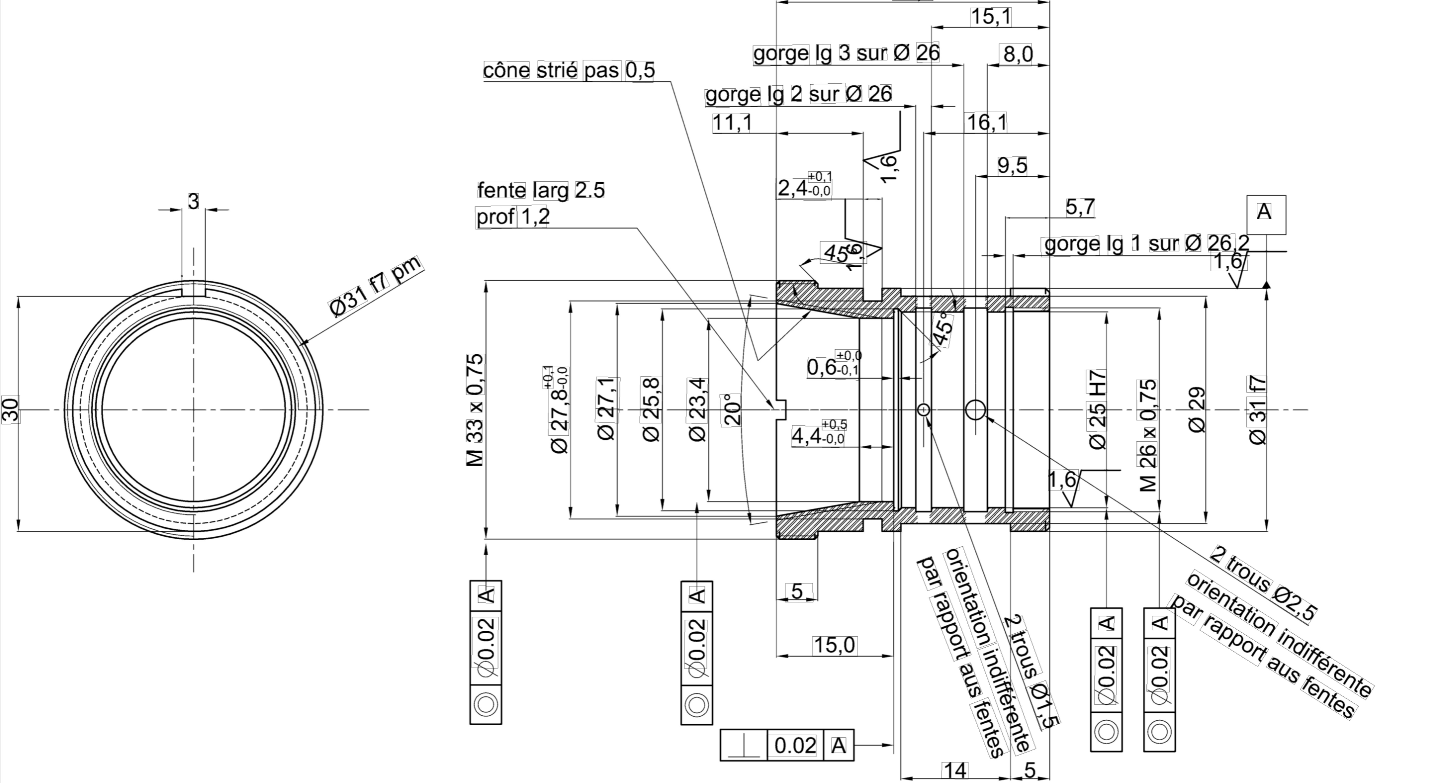

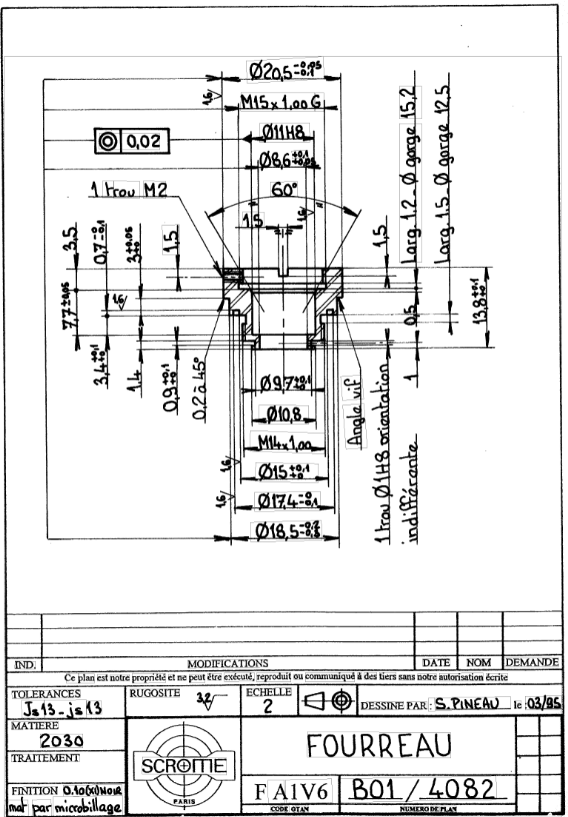

**Partial detection of floats**:
We probably have below 20% of value not detected if the drawing is a good pdf with a drawing generated by the machine.  
The scores are worse if we use a drawing which is manually generated.  
We will try to see if the model can still learn meaningful patterns with those scores, and we will try to improve the detection by using finer dpi or other preprocessing parameters.  
We believe that the features does not obviously need to be discarded if it contains missing values: we can add a quality drawing indicator as follows:

**Drawing quality indicator to distingish between low detectable drawing and higher detectables drawings**
We add a feature in the dataset which indicates if the pdf is rather a hand written one or rather a clean machine generated one (screening the image as a numpy array and assessing the distribution of pixels intensity between 0 and 255 with descriptive statistics, the hand written old documents difficult to OCR has a different profile than the clean new pdf ones: we flag those for the machine learning model to be informed).  

**Case of the complete missing tolerance bands**
It happen often that the complete tolerance band is missing as we see in the chapter before, which means that no value between 0 and 1 is detected.
This is probably the case when the OCR is not detecting the float element but 2 integers with a split at position of '.' or ','.
We can certainly try to improve this behavior but we let it aside in the perimeter of this Capestone.

In this case we will:  
- cross-check how the flag on drawing quality is representative if this population with missing tolerance band.  
- impute the missing points with some data: We group the points in the same range of dimension, and we use the median value of this group to fill the missing (will apply this fillna() at the end of the EDA section).  

#### Outliers

When do we remove outliers ?
- The outlier removal will take place at the end of the preprocessing step when the data is still in a dataframe format (before converting to numpy array for ML).
- We will generate a clean dataset without outliers and perform the ML tasks on this set.  

Validity of test scores
- We highlight the following: the MAE scores which will be obtained from the test values predicted by the trained model are valid only on test data free from outliers.

Methodology for outliers removal on a specific feature:
- First visualize the distribution with all data.
- We can already filter manually some outliers.
- Observe if the distribution is close to normal, or can be transformed to a normal distribution. In this case we can apply a zscore filtering, else we need to select a more robust method based on median for instance. If this is the case apply the automatic thresholding to classify outliers.   
- If nothing automatic can be set, define a threshold manually and classify the data outside the threshold as outliers.   
- Visualize the results of the removal, compute the % of data removed.  

Note we performed some outliers removal at different stage in our project: During extraction of the pdf source, we checked the list of digits detected in each pdf drawing for outliers based on their distance to average (only on the positive side, since the low bound is 1 for the dimension band). 

### Relationship between features and with target

In this section we will try to answer the questions we raised.  

To do this, we explore specific aspects and relationships amongst the features themselves and with the target.  

#### 1. What is the distribution shape of the target ?

The targets contains a few nan or zero values that we have deleted during the cleaning phase.  
We see below how the data profile has been set to a normal distribution with the log transformation we performed.  

In [ ]:
if plotting_trigger == 1:
    
    displ=sns.distplot(df_merged_used['cout_unitaire_pour_la_qte_demandee'],
                       kde=True,
                       bins=50,
                       fit=stats.norm)
    
    displ.set_xlabel('cout_unitaire_pour_la_qte_demandee (log)')
    
    plt.title('Distribution of cout_unitaire_pour_la_qte_demandee'\
              +'\n(log10 scaling, fit normal distribution)',
              loc='left')
    
    plt.show()

#### 2. What is the distribution shape of the feature, where are the outliers in features and target ?


As explained in the section above, we perform manual removal of some outliers and define a function which flags the outliers based on the z-score threshold.  
This is performed after the data has been looked at and set to a normal distribution for those distributions which were skewed.  

We create a new feature called 'outlier', with a default value at 0, indicating that the corresponding row is not an outlier.  
The outliers manually detected are then flagged with a value =2, the automatic datected receive a flag equal to 1.

We can verify to which extend our outlier removal method is appropriate by checking:  
- Distribution visualisation
- % removed

At the end of this process we save again a slice of our dataframe with all outliers filtered.

In [ ]:
# We start with the following dataframe
df_merged_used.head()

Manual filtering:   

Below we can see a lot of different manual filters prepared. For instance we remove the projects with only production of one unit, which correspond probably to a prototype, and which has a high risk to have a non standard cost which we do not want to have in our train set.  

Those possible manual filters have not been all used in the version of the Capstone uploaded for the review. We need more time to analyse in more details which outliers are impacting our training set scores in the ML phase.  

In [ ]:
# Manual outliers deletion (Manual = set outliers index to number '2')

# Initialize outliers column

df_merged_used['Outlier']=0


# Drop rows with target value above a maximum or below a minimum

df_merged_used.loc[df_merged_used[\
            df_merged_used['cout_unitaire_pour_la_qte_demandee']>2.74].index,
                   'Outlier']=2

df_merged_used.loc[df_merged_used[\
            df_merged_used['cout_unitaire_pour_la_qte_demandee']<0.7].index,
                   'Outlier']=2


# Identify outliers with out-of-range batch size

df_merged_used.loc[df_merged_used[\
    df_merged_used['chiffrage_pour_la_qte_demandee_quantite_unite']>2.7].index,
                   'Outlier']=2

df_merged_used.loc[df_merged_used[\
   df_merged_used['chiffrage_pour_la_qte_demandee_quantite_unite']<0.4].index,
                    'Outlier']=2


# Identify outliers with out-of-range features

df_merged_used.loc[df_merged_used[\
            df_merged_used['ratio_interne']<0.3].index,
                   'Outlier']=2

#df_merged_used.loc[df_merged_used[\
#            df_merged_used['ratio_usinage']>0.9].index,
#                   'Outlier']=2

df_merged_used.loc[df_merged_used[\
            df_merged_used['ratio_matiere']>0.35].index,
                   'Outlier']=2

df_merged_used.loc[df_merged_used[\
            df_merged_used['quality_indicator_kurtosis']<0].index,
                   'Outlier']=2

df_merged_used.loc[df_merged_used[\
            df_merged_used['quality_indicator_kurtosis']>80].index,
                   'Outlier']=2


#df_merged_used.loc[df_merged_used[\
#            df_merged_used['quality_indicator_variance']>3200].index,
#                   'Outlier']=2

#df_merged_used.loc[df_merged_used[\
#            df_merged_used['quality_indicator_skewness']>-2.5].index,
#                   'Outlier']=2

df_merged_used.loc[df_merged_used[\
            df_merged_used['quality_indicator_mean']>0.1830].index,
                   'Outlier']=2

#df_merged_used.loc[df_merged_used[\
#            df_merged_used['±']<4].index,
#                   'Outlier']=2

#df_merged_used.loc[df_merged_used[\
#            df_merged_used['dimension_band_count']<3].index,
#                   'Outlier']=2

#df_merged_used.loc[df_merged_used[\
#            df_merged_used['dimension_band_max']>350].index,
#                   'Outlier']=2

#df_merged_used.loc[df_merged_used[\
#            df_merged_used['dimension_band_median']>1.6].index,
#                   'Outlier']=2

#df_merged_used.loc[df_merged_used[\
#            df_merged_used['dimension_band_count']>40].index,
#                   'Outlier']=2

Z-score filtering:  

We use a threshold at 3 standard deviations from the mean. Again here we see that we do not apply the filter on all our quantitative continuous features.

In [ ]:
# Outliers identification on quantitative features
# (Z-Score based removal = set outliers index to number '1')

# Print list of numerical columns for column selection among those ones

print('Quantitative features: \n',quant_features,'\n')


# List which column we would like to check

outliers_col=[\
              #'cout_unitaire_pour_la_qte_demandee',
              'tolerance_band_mean',
              'tolerance_band_median',
              'dimension_band_mean',
              'dimension_band_min',
              'dimension_band_median',
              'dimension_band_std',
              'dimension_band_quantile_80',
              'dimension_band_irq',
              #'quality_indicator_kurtosis',
              #'quality_indicator_variance',
              #'quality_indicator_skewness',
              #'ratio_interne',
              #'ratio_externe',
              #'ratio_outils',
              'ratio_reglage',
              'ratio_controle',
              #'ratio_usinage',
              #'ratio_autres_internes',
              #'ratio_matiere',
              #'ratio_traitements',
              #'ratio_meca',
              #'ratio_peinture',
              #'ratio_autres_externes',
             ]

print('Selected for zscores outliers detection: \n',outliers_col,'\n')

# Store this variable for usage in other notebooks

%store outliers_col

# Note that distribution plot of the features considered for outlier removal
# is controlled in the plots shown later below

# Compute train mean/std, calculate and store zscore values

data_mean = df_merged_used[outliers_col].replace(0,np.nan).mean()

data_std = df_merged_used[outliers_col].replace(0,np.nan).std()

z_scores = np.abs(df_merged_used[df_merged_used[outliers_col]!=0][outliers_col]\
                  - data_mean) / (data_std)

for c in outliers_col:
    
    df_merged_used['zscore_{}'.format(c)]=\
                    np.abs((df_merged_used[df_merged_used[c]!=0][c] \
                            - df_merged_used[c].replace(0,np.nan).mean()) \
                                / (df_merged_used[c].replace(0,np.nan).std()))
    
    df_merged_used['zscore_{}'.format(c)].fillna(0, inplace=True)

# Apply threshold

threshold=3

below_threshold = np.abs(z_scores.fillna(0)) <= threshold

# Find outliers

mask = below_threshold.all(axis=1)

df_merged_used.loc[~mask,'Outlier']=1

# Display lines with outliers

df_merged_used[df_merged_used['Outlier']==1]

# Output a new dataframe without outliers

df_clean=df_merged_used[df_merged_used['Outlier']!=3]\
        .iloc[:,~df_merged_used.columns.str.contains('zscore')].copy()

# Store this variable for usage in other notebooks

%store df_clean

# Summarize the percentage of outliers detected with the given threshold

print('\nThreshold used for z-score outliers detection: {}'\
      .format(threshold))

print('Number of outliers detected: {}'\
        .format(len(df_clean[(df_clean['Outlier']!=0)])))

print('Percentage of outliers detected: {:.1f}%'\
      .format(100*len(df_clean[df_clean['Outlier']!=0])/len(df_clean)))

In [ ]:
# Display all quantitative features distributions with outliers indication
# Note the zero values on abscissa axis are deleted for those plots

if plotting_trigger == 1:
    
    for c in [i for i in quant_features if 'zscore_' not in i]:
                
        y=df_clean['cout_unitaire_pour_la_qte_demandee']
        x=df_clean[df_clean[c]!=0][c]
        
        jnpl=sns.jointplot(x=x,
                           y=y,
                           kind='scatter',
                           hue=df_clean['Outlier'],
                           palette=['g','orange','red'],
                           alpha=0.4,
                           #size=20,
                           height=8)

        if c in outliers_col and c in transform_col:
            indicator='used'
            jnpl.set_axis_labels('{} (log)'.format(c),
                                 'cout_unitaire_pour_la_qte_demandee (log)')

        if c in outliers_col and c not in transform_col:
            indicator='used'
            jnpl.set_axis_labels('{}'.format(c),
                                 'cout_unitaire_pour_la_qte_demandee (log)')
            
        elif c in transform_col:
            indicator='not used'    
            jnpl.set_axis_labels('{} (log)'.format(c),
                                 'cout_unitaire_pour_la_qte_demandee (log)')

        else:
            indicator='not used'    
            jnpl.set_axis_labels('{}'.format(c),
                                 'cout_unitaire_pour_la_qte_demandee (log)')

        #plt.text(x=-1,
        #         y=0,
        #         s='(feature {} for outlier detection)'.format(indicator))
        
        plt.show()
        print('\n\n\n')

The outliers removal performed seem to be reasonable in a first stage. We delete those outliers for the next phase and save a copy of our filtered dataframe.  

In [ ]:
# We save the clean dataframe
df_clean=df_clean[df_clean['Outlier']==0].copy()

We review again the dataset statistics after outliers removal and droping again features with low variance.

In [ ]:
# After outliers removal we need to drop again features with low variance
             
remove_feat(df_clean)

# We print again the dataset statistics
print('\n')
get_stats(df_clean)

In [ ]:
# Describe quantitative discrete or continuous data

quant_features=list(df_clean\
                    .select_dtypes(float)\
                    .describe(percentiles=[0.5])\
                    .T\
                    .index)
print(df_clean\
      .select_dtypes(float)\
      .describe(percentiles=[0.5])\
      .T)

In [ ]:
# Describe categorical boolean indicator variables

df_bool=df_clean\
        .select_dtypes(int)\
        .copy()

bool_features=list(pd.DataFrame([df_bool[df_bool==0].count(),
                                 df_bool[df_bool==1].count()])\
                   .T\
                   .index)

print(pd.DataFrame([df_bool[df_bool==0].count(),
                    df_bool[df_bool==1].count()])\
      .T)

In [ ]:
# Describe the other categorical variables

cat_features=list(df_clean\
                  .select_dtypes('category')\
                  .describe()\
                  .T\
                  .index)

print(df_clean\
      .select_dtypes('category')\
      .describe()\
      .T)

In the previous section we looked at the quantitative variables, their distribution and the outliers.  In the section below we plot the categorical variables. 

In [ ]:
# Display all distributions of categorical features
# (delected from the 2 types we used: category and int)

# Print list of categorical columns 
print('Categorical features: \n',
      bool_features+cat_features,
      '\n')

In [ ]:
# Plot the categorical features

if plotting_trigger == 1:

    for c in bool_features+cat_features:

        catpl=sns.catplot(x=c,
                          y='cout_unitaire_pour_la_qte_demandee', 
                          data=df_clean,
                          height=4,
                          aspect=4)
        
        catpl.set_axis_labels('{}'.format(c),
                              'cout_unitaire_pour_la_qte_demandee (log)')

        plt.show()

We also generate a dataframe profile, to be used later as a reference.

In [ ]:
# Profiling cleaned input data

if profiling_trigger == 1:
    
    cleaned_no_outliers_profile=\
        df_clean.profile_report(title='Report after cleaning &outliers removal',
                                minimal=True,
                                explorative=False,
                                correlations={'pearson': {'calculate': False},
                                              'spearman': {'calculate': True}},
                                missing_diagrams={'heatmap': False,
                                                  'dendrogram': False})
    
    cleaned_no_outliers_profile.to_file(cpst_path\
                                        +'/cleaned_no_outliers_profile.html')

#### 3. What are the top and lowest drivers for the target value within the features space ?

To answer the question we can first show the pairplots of all our features and target in a matrix to visualize possible correlation, using seaborn pairplot() function for quantitative data.  
This covers only the quantitative data.  
(We realize that those plot are not very convenient to use when we have a large dimensionality).  

In [ ]:
# Pairplots
# (to be looked at in the .png file generate with a sufficient zoom factor)
# The features with type category are excluded in this part of the analysis,
# we look here at some quantitative features selected.

if plotting_trigger == 2:
    
    sns_pairplot=sns.pairplot(df_clean[quant_features])
    
    sns_pairplot.savefig('./plots/sns_pairplot.png')
    
    plt.show()

From this chart we identify the following quantitative features as having an impact on the target:
 - 'chiffrage_pour_la_qte_demandee_quantite_unite'
 - '±'
 - 'Ra'
 - 'Ø'
 - 'quality_indicator_kurtosis'
 - 'dimension_band_count'
 - 'tolerance_band_count'
 - 'tolerance_band_median'

Let's visualize those values in more details:

In [ ]:
# Plotting some quantitative variables against the target
# Removing this time the zero values for the plot

quant_features_top=[\
                    '±',
                    'Ra',
                    'Ø',
                    'quality_indicator_kurtosis',
                    'tolerance_band_count',
                    'dimension_band_count',
                    'tolerance_band_median',
                   ]
#'quality_indicator_skewness',
#'quality_indicator_variance',
#'quality_indicator_mean'

if plotting_trigger == 1:
    
    for c in quant_features_top:
        
        #print(c)
        
        x=df_clean[df_clean[c]!=0][c]
        y=df_clean[df_clean[c]!=0]['cout_unitaire_pour_la_qte_demandee']
        
        rgpl=sns.regplot(x=x,
                         y=y,
                         marker='+')
        
        if c in transform_col:
            rgpl.set_xlabel('{} (log)'.format(c)) 
        else:
            rgpl.set_xlabel('{}'.format(c))
        
        rgpl.set_ylabel('target (log)')
        plt.title('Regplot of cout_unitaire_pour_la_qte_demandee',
                  loc='left')
        
        plt.show()

We observe in those plots that the correlations between the variables are not as expected when we remove the zeros: tolerance band count and median seem to be neutral to the target.  

We expected the complexity of the product and therefore the number of toleranced elements to increase together with the target (similar to what we observe for the symbols and in particular the ± one).  

We will come back to this point when looking at the quality indicator for the drawings in a next question.

An additional possibility for analysing the costs drivers is to quantify the pairwise correlations of columns using the standard pearson correlation coefficient.  

We show those values in a correlation matrix displayed as a heatmap with amazing colors.  

The features with type category would be excluded when compute dataframe correlation factor with df.corr(), therefore we change the dataframe type to compute those.  

In this matrix we therefore capture all features.  

In [ ]:
# Heatmap of pairwise pearson correlations

df_clean_corr=df_clean.astype(np.number)

if plotting_trigger == 1:
    
    plt.figure(figsize=(28, 30))
    
    heatmap=sns.heatmap(df_clean_corr.corr(method='pearson', min_periods=1),
                        vmin=-1,
                        vmax=1,
                        annot=False,
                        cmap='bwr',
                        cbar_kws=dict(orientation='horizontal',
                                      anchor=(0, 0.5),
                                      pad=0.01))
    
    heatmap.set_title('Correlation Heatmap: pairwise correlations '+\
                      'excl. NA/null - pearson coeff',
                      fontdict={'fontsize':12},
                      pad=12)
    
    plt.tick_params(axis='x',
                    which='both',
                    labelbottom = False,
                    top=True,
                    labeltop=True,
                    labelrotation=90)
    
    plt.show()

This is an interesting view ans similar to the pairplot we see it contains a lot of information. We are interested to look at the most or the least important correlations, let's compute and sort them below:

In [ ]:
# Top 20 pearson correlations features to target

df_clean_corr_top20=np.abs(df_clean.corr(method='pearson',
                                         min_periods=1)\
                       .cout_unitaire_pour_la_qte_demandee)\
                        .sort_values(ascending=False)[1:20]\
                        .to_frame()\
                        .rename(columns={'cout_unitaire_pour_la_qte_demandee'\
                                         :'Correlation to target'})
df_clean_corr_top20

From this table we can easily control our findings from the previous chart, and start to quantify and classify which features are more or less correlated to the target (at least linearly correlated - just what we can see with the pearson coefficient).  

We find it very interesting to see that our intuition regarding the features of importance is encouraged by the numbers: 
In particular the drawing complexity modeled by the symbols detected in drawings is linked with our target, even more than some parameters like the machine selected for the operations or the blocks of additional costs like methods or control.  
It tells us that our pdf source features will contribute to the predictions in a significant manner.

We also see that the dimension band lenght as a greater impact on the target that its level of magnitude itself, which was no expected.

We can visualize in more details the most influent categorical features which were not available in the pairplot above.  

In [ ]:
# Plotting top categorical variables against the target

cols_cat_top=\
    [c for c in df_clean_corr_top20.index.to_list() if c not in quant_features]

if plotting_trigger == 1:
    
    for c in cols_cat_top:
        
        x=df_clean[c]
        y=df_clean['cout_unitaire_pour_la_qte_demandee']
        
        vlpl=sns.violinplot(x=x,
                            y=y,
                            data=df_clean,
                            size=5,
                            scale='count')
        
        vlpl.set_xlabel('{}'.format(c))
        vlpl.set_ylabel('target (log)')    
        
        plt.title('Swarmplot of target (log)',loc='left')
        
        plt.show()

We also want to list the features which have a pearson correlation coefficient close to zero (Which does not obviously mean those are decorrelated).  

In [ ]:
# Bottom 20 pearson correlations features to target

df_clean_corr_tail=np.abs(df_clean.corr(method='pearson',
                                        min_periods=1)\
                       .cout_unitaire_pour_la_qte_demandee)\
                        .sort_values(ascending=False)[-20:]\
                        .to_frame()\
                        .rename(columns={'cout_unitaire_pour_la_qte_demandee'\
                                         :'Correlation to target'})

df_clean_corr_tail

Some findings are not surprising: s_t_meca_eur_piece_exist have low impact because the absolute values of this parameter is very small compared to target.

On the low correlated values we are surprised to find tolerance_band_median which we had expected to correlate with the target.  

We can try to further investigate the parameters correlated to the dimension band level (we select the median as a robust indicator of the level):

In [ ]:
# Top 20 pearson correlations features to dimension_band_median

df_clean_corr_top=np.abs(df_clean.corr(method='pearson',
                                       min_periods=1)\
                       .dimension_band_median)\
                        .sort_values(ascending=False)[1:30]\
                        .to_frame()\
                        .rename(columns={'dimension_band_median'\
                                         :'Correlation to dimension_band_median'})

df_clean_corr_top

The top correlations are the statistical ones, which are expected and we are not interested in those.
The interesting ones which come immediately after are related to: client, type of operations, presence of costs blocks like cout_reglage_eur_piece_exist.
But the correlation coefficient found seem low, and we find no correlation to the pdf quality indicators.

As a conclusion on the section related to main features impacting the target, we also add the following:
- We do not see a specific outstanding feature, the correlation coefficient are all below 0.65.  
- The most correlated features seem to reflect the density of elements on the pdf chart. 
- The dimension parameter in absolute values does not seem to have a large impact on the target, contrary to the count of it.  
- The tolerance band median has a low correlation with target.  

#### 4. What are the features which seem strongly correlated within each other ?

We analyse the top correlated features:

In [ ]:
df_corr=df_clean.corr(method='pearson', min_periods=1)
df_corr.where((0.75>df_corr)&(df_corr>0.50)).stack()

We find out the following:
- Many of the statistics for the tolerance and dimension bands are correlated within each other - this is expected.

We see as well other interesting patterns:
- s_t_meca_eur_piece is correlated to nature_traitement_s_t_mecanique_12_electro_erosion
- quality_indicator_skewness (and the other ones) are correlated to path_6_calc_c0000007scrome
- ratio_interne correlated with ratio_usinage
- ratio_externe correlated with ratio_traitements     
- op3_type_fraisage_cn_3_axes correlated with op4_exist
- op2_type_rectif_plane is correlated to nature_matiere_matiere_1_steel_tool
- nature_traitement_s_t_traitement_1_nitruration  correlated with nature_matiere_matiere_1_steel_tool 

The quantity of elements detected is linked, for instance we find:
- Ø is correlated to Ra
- Dimension band count is correlated to ±

#### 5. What do we observe from the feature related to drawings quality

We setup an indicator of the drawing quality based on the kurtosis of the pixels distribution in the image.  
We also adde other statistics for the pixel distribution but the kurtosis was making more sense for us.
We make preliminary checks to validate this indicator as a way to distinguish between drawings (as explained in the section dedicated to pdf source presentation).

In [ ]:
# We check if the kurtosis is a good classifier for our hand written digits,
# seems that 10 is a good thresh between hand and machine
# by plotting a few images and the corresponding indicator value

from PIL import Image
import os
import glob

List_kur=list(df_merged[['quality_indicator_kurtosis','pdf_file']]\
              .sort_values('quality_indicator_kurtosis')\
              .dropna()['quality_indicator_kurtosis'])

List_pdf=list(df_merged[['quality_indicator_kurtosis','pdf_file']]\
              .sort_values('quality_indicator_kurtosis')\
              .dropna()['pdf_file'])

List_images=[i[:-4]+'_page1from*.jpg' \
             if i[-2]=='d' \
             else i[:-5]+'_page1from*.jpg' \
             for i in List_pdf[::35]]

List_kurtos=[i for i in List_kur[::35]]

for i,j in zip(List_kurtos,List_images):
    
    print('\n\n\nquality_indicator_kurtosis: {:.1f}'.format(i))
    
    jn=glob.glob(os.path.normpath(j))[0]
    
    print(jn)
    
    if plotting_trigger == 1:
        
        im=Image.open(jn)
        
        size=600,600
        
        im.thumbnail(size, Image.ANTIALIAS)
        
        display(im)

We define pdf_lowqual as a indicator of quality_indicator_kurtosis below or above threshold of 10-15.

We see that those drawing quality assessment features have a significant correlation with:  
- 'dimension_band_count'  
- '±'  

but also with:
- 'chiffrage_pour_la_qte_demandee_quantite_unite'  
- 'tolerance_band_count_exist'  

In [ ]:
# Top 10 pearson correlations features to dimension_band_median
np.abs(df_clean.corr(method='pearson', min_periods=1)\
                       .pdf_lowqual)\
                        .sort_values(ascending=False)[1:20]\
                        .to_frame()\
                        .rename(columns={'pdf_lowqual':'Correlation to pdf_lowqual'})

As a consequence the drawing quality assessment features also have a significant correlation on the target, since the 3 features above are drivers for the target variance.  

This is what we observe in the plot below:  

In [ ]:
# Position of low quality drawings group on log10(1+target) distribution

if plotting_trigger == 1:
    
    x=df_clean['cout_unitaire_pour_la_qte_demandee']
    
    sns.displot(x=x,
                kind='hist',
                hue=df_clean['pdf_lowqual'],
                multiple='stack')
    
    plt.title('Position of low quality drawings group on target distribution')
    
    plt.xlabel('cout_unitaire_pour_la_qte_demandee (log)')
    
    plt.show()

The correlation between quality_indicator_kurtosis and elements of the drawing was expected: in the paragraph above we show the ckecks we did manually on the drawings, where we computed up to 40% of missed information when the drawing is hand written.  


The correlation of quality_indicator_kurtosis to chiffrage_pour_la_qte_demandee_quantite_unite was on the contrary not expected, this is what we can see below.  
It probably means that the parts produced in largers quantities are more often described with drawings of low quality, a fact which is explainable by the business.  

In [ ]:
# Position of low quality drawings group on target (log)
# and ± feature distributions

if plotting_trigger == 1:
    
    y=df_clean['cout_unitaire_pour_la_qte_demandee']
    x=df_clean['±']
    
    jnpl=sns.jointplot(x=x,y=y, kind='scatter', hue=df_clean['pdf_lowqual'])
    
    plt.title('Position of low quality drawings group on target and ± feature distributions',
              y=1.25,
              loc='right')
    
    jnpl.set_axis_labels('±',
                         'cout_unitaire_pour_la_qte_demandee (log)')
    
    plt.show()

We confirm this hypothesis by exploring further the relation between part quantities and drawing quality, see below the strong correlation:  

In [ ]:
# Relation between drawing quality indicator and chiffrage_pour_la_qte_demandee_quantite_unite

if plotting_trigger == 1:
    
    y=df_clean['chiffrage_pour_la_qte_demandee_quantite_unite']
    x=df_clean['quality_indicator_kurtosis']
    
    jnpl=sns.jointplot(x=x,
                       y=y,
                       kind='reg')
    
    jnpl.set_axis_labels('quality_indicator_kurtosis',
                         'chiffrage_pour_la_qte_demandee_quantite_unite')
    
    plt.title('Relation between drawing quality indicator and \nchiffrage_pour_la_qte_demandee_quantite_unite',
              y=1.25,
              loc='right')
    
    plt.show()

We now investigate the relation between drawings quality and the detection of a tolerance band.  
We see below that with low quality indicator we have a higher frequency of misdetection of the tolerance band (no detection or small lenght).  

In [ ]:
# Relation between drawing quality indicator and tolerance band

if plotting_trigger == 1:
    
    x=df_clean['quality_indicator_kurtosis']
    y=df_clean['tolerance_band_count']
    
    displ=sns.displot(x=x,
                      y=y,
                      bins=8,
                      cbar=True,
                      height=5,
                      aspect=1.2,
                      kind='hist',
                      stat='frequency')
    
    displ.set_axis_labels('quality_indicator_kurtosis',
                          'tolerance_band_count (bins)')
    
    plt.title('Relation between drawing quality indicator \nand size of tolerance band detected (Frequency)',y=1.1)
    
    plt.tight_layout()
    
    plt.show()

As a conclusion, we can say that the quality of the drawing influences the features we can extract from it. Those low quality drawings are not appearing uniformly on the set of drawings we have, but those are more present in specific categories such as drawings of parts produces in larger batch sizes, and we will need to monitor the prediction scores resulting from the machine learning into those specific categories, as those might differ.  

The target will be utlimately to get more datapoint with newer and more modern drawings, to be able to eventually filter and get rid of this special low quality drawing category and generate overall better predictions scores.  

#### 6. What trend do we observe in dimensions and tolerance bands

We want to compare the evolution of features such as the mean and median in both the dimensions and tolerance bands across the different magnitude of the target:
We expect high target (high costs) to correspond with products with larger dimensions and smaller tolerances.  

The trends we see in the charts produced below are not so clear:  
- The quantity of information on the tolerance bands is limited, many pdf have dimensions band but no tolerance associated, which is a detection error.  
- It seems that the mean of the dimensions band is higher for high targets.

In the chart below we consider only the datapoints having both bands detected, which gives a small number of points in total.

In [ ]:
# Define a set of features to be checked

df_clean_bands=df_clean[['cout_unitaire_pour_la_qte_demandee',
                         'tolerance_band_count',
                         'dimension_band_count',
                         'tolerance_band_min',
                         'tolerance_band_max',
                         'tolerance_band_mean',
                         'tolerance_band_std',
                         'tolerance_band_median',
                         'tolerance_band_quantile_20',
                         'tolerance_band_quantile_80',
                         'tolerance_band_irq',
                         'dimension_band_min',
                         'dimension_band_max',
                         'dimension_band_mean',
                         'dimension_band_std',
                         'dimension_band_median',
                         'dimension_band_quantile_20',
                         'dimension_band_quantile_80',
                         'dimension_band_irq']].copy()

df_clean_bands.dropna(inplace=True)

In [ ]:
# Apply a min max scaler on the features, we keep the target without scaling

from sklearn import preprocessing

y=df_clean_bands['cout_unitaire_pour_la_qte_demandee'].values

x=df_clean_bands\
            .drop(['cout_unitaire_pour_la_qte_demandee'], axis=1).values

columns=df_clean_bands\
            .drop(['cout_unitaire_pour_la_qte_demandee'], axis=1).columns

min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(x)

df_clean_bands = pd.DataFrame(x_scaled, columns= columns)

df_clean_bands['cout_unitaire_pour_la_qte_demandee']=y

df_clean_bands.head()

In [ ]:
# We stack the dataframe and generate the category Dimension / Tolerance in one column, to be able to use it as hue argument in plot

df_clean_bands.columns = df_clean_bands.columns.str.split('_band_', expand=True)

df_clean_bands = df_clean_bands.rename({np.nan: 'cout_unitaire_pour_la_qte_demandee'},
                                       axis=1,level=1)

df_clean_bands = df_clean_bands.rename({'cout_unitaire_pour_la_qte_demandee': 'dimension'},
                                       axis=1,level=0)

df_clean_bands['tolerance','cout_unitaire_pour_la_qte_demandee']=\
        df_clean_bands.iloc[:, df_clean_bands.columns.get_level_values(1)=='cout_unitaire_pour_la_qte_demandee']

df_clean_bands_stacked=df_clean_bands.stack(level=0,dropna=True).copy()

df_clean_bands_stacked.reset_index(inplace=True)

df_clean_bands_stacked.drop(['level_0'],axis=1, inplace=True)

df_clean_bands_stacked.dropna(how='any', inplace=True)

df_clean_bands_stacked.rename(columns={'level_1':'band'}, inplace=True)

#Define bin for costs magnitude, 1 is low cost 10 if high costs

df_clean_bands_stacked['cost_bin']=pd.cut(df_clean_bands_stacked['cout_unitaire_pour_la_qte_demandee'],
                                          10,
                                          labels=['1', '2', '3','4', '5', '6','7', '8', '9', '10'])

df_clean_bands_stacked.head(5)

In [ ]:
# PLotting the distribution of several statistics for tolerance and dimension bands

cols=['mean','median','quantile_20','quantile_80']

if plotting_trigger == 1:
    
    for c in cols:
        
        print('\n\nDistribution of the {} for both tolerance and dimension bands'\
              .format(c))
        
        jnpl=sns.displot(data=df_clean_bands_stacked,
                         x=c,
                         y='cost_bin',
                         bins=10,
                         col='band',
                         kind='hist',
                         height=4,
                         aspect=1,
                         cbar=True,
                         stat='frequency')
        
        jnpl.set_axis_labels('minmax_scaler({})'.format(c),
                             'target (1=low, 10=high)')
        
        jnpl.fig.axes[0].invert_yaxis()
        
        plt.tight_layout()
        
        plt.show()

To continue the preparation for the ML and after having investigated the tolerance band data as received from the feature extraction, we will now impute the missing points related to tolerance band with some data:  
- Our intuition is to link to tolerance band parameters to be estimated to the main dimensions.
- We check the correlation between tolerance_band_exist and the features. 

In [ ]:
# Top 10 pearson correlations features to dimension_band_median

np.abs(df_clean.corr(method='pearson', min_periods=1)\
                       .tolerance_band_count_exist)\
                        .sort_values(ascending=False)[1:20]\
                        .to_frame()\
                        .rename(columns={'tolerance_band_count_exist':'Correlation to tolerance_band_count_exist'})

We could group the points per range of '±' which seem to be well correlated to the tolerance band existance and for which we have 'only' around 20% completely missing values.  

It also make sense, since this should model the quantity of values we should be able to detect.

Then it would make sense to add a grouping for the points in the same range of dimension since it is also correlated to the tolerance band and it is explainable from a technical point of view: we use the 'Q20' value of this group to fill the missing, which seems more robust than the mean.  

We want to fill the missing values in the following features:

In [ ]:
# Making a list of the tolerance bands columns to fill in:

fillna_cols=['tolerance_band_min',
             'tolerance_band_max',
             'tolerance_band_mean',
             'tolerance_band_std',
             'tolerance_band_median',
             'tolerance_band_quantile_20',
             'tolerance_band_quantile_80',
             'tolerance_band_irq']

We perform binning again and adjust the bin number on the values dimension_band and ± as we see we have a risk to get empty groups (if we have too many groups) preventing from calculating a median value for the tolerance band feature we want to fill-in.

In [ ]:
# We use the quantile-based discretization function qcut 

df_clean['dimension_band_median_bins']=pd.qcut(df_clean['dimension_band_median'],
                                               5,
                                               labels=[1,2,3,4,5])#median
df_clean['±_bins']=pd.qcut(df_clean['±'],
                           5,
                           labels=[1,2,3,4,5])

# We generate the groupby object

col_groups=['dimension_band_median_bins','±_bins']
grouped=df_clean.groupby(col_groups)

# We check and element of the group and the size of the groups
# We check that we have a median value for the tolerance band mean in each of the groups
# This is important as we will use it to fill in the nan values in the fillna_cols series

display(grouped.get_group((1,2)).head())
display(grouped.size())
display(grouped.median()['tolerance_band_max'])

In the 2 tables above we observe our 5 x5 = 25 groups and the median values calculated for tolerance_band_max (parameter taken as an exemple).  

We now fill in the missing parameters with median and flag those for better identification later on.  

Finaly we prepare the plotting of those filled-in parameters.

In [ ]:
# We set a flag to be able to see the transformation in a plot afterwards
df_clean['fillna_flag'] = np.where(df_clean[fillna_cols[0]].isna(),1,0)

# We perform the replacement
df_clean[fillna_cols] = df_clean.groupby(col_groups)[fillna_cols]\
                            .transform(lambda x: x.fillna(x.median()))

# We finally control the remaining na values
print('nan values remaining in dataframe: ',df_clean.isna().sum().sum())

# We impute the remaining missing with the median in each column
print('imputing the median...')
for c in fillna_cols:
    df_clean[c].fillna(df_clean[c].median(), inplace=True)

# Final check presence of na values
print('nan values remaining in dataframe: ',df_clean.isna().sum().sum())

In [ ]:
# Plotting the quantitative tolerance band variables against the target
# We control where the points automatically filled-in are located

if plotting_trigger == 1:
    
    for c in fillna_cols:
        
        x=10**df_clean[c]-1
        
        y=df_clean['cout_unitaire_pour_la_qte_demandee']
        
        rgpl=sns.scatterplot(x=x,
                             y=y,
                             hue=df_clean['fillna_flag'],
                             alpha=0.4)
        
        rgpl.set_xlabel('{}'.format(c))
        rgpl.set_ylabel('target (log)')   
        
        plt.title('Scatterplot of cout_unitaire_pour_la_qte_demandee',
                  loc='left')
        
        plt.show()

We observe that the missing points are located reasonably compared to existing points, although not covering the full range. 

#### 7. Do we see specific groups or clusters in the target, explained by some features ?

Will be investigated later in the project, was out of scope in the Capestone for time reasons.  

#### 8. Does it help to perform feature engineering to model volumetric information ?

(by adding polynomial features up to degree 3 to the distance extracted from pdf drawing).  
Will be investigated later in the project, was out of scope in the Capestone for time reasons.  

### Cleaned dataset for ML

We finally output a dataframe cleaned and prepared for the next phase:  
- We can save it as npz file but we will just need to recover the datatypes when loading  
- We can also store it in the memory if we plan to use it immediately after 

We note the cardinality of this set just below 300.

In [ ]:
# We finally clean the dataframe from the columns generated as support for EDA

df_clean.drop(['Outlier','dimension_band_median_bins','±_bins','fillna_flag'],
              axis=1, inplace=True)

In [ ]:
# Profiling input data before ML
if profiling_trigger == 1:
    
    ML_input_profile=df_clean.profile_report(title='Report before ML',
                                             minimal=True, explorative=False,
                                             correlations=\
                                             {'pearson': {'calculate': False},
                                              'spearman': {'calculate': False}},
                                             missing_diagrams=\
                                             {'heatmap': False,
                                              'dendrogram': False})
    
    ML_input_profile.to_file(cpst_path+'/ML_input_profile.html')

In [ ]:
# Build 2 different dataframes filtering sources for alternative ML analysis

df_clean_scrome=df_clean[(df_clean['path_6_calc_other']!=1)].copy()

display(df_clean_scrome.info())


df_clean_other=df_clean[(df_clean['path_6_calc_c0000007scrome']==0)].copy()

display(df_clean_other.info())

In [ ]:
# Save dataframe as .npz file

np.savez(cpst_path+'/df_clean_scrome.npz',
         features=df_clean_scrome,
         names=df_clean_scrome.columns)

np.savez(cpst_path+'/df_clean_other.npz',
         features=df_clean_other,
         names=df_clean_other.columns)

In [ ]:
# Store the clean dataframe for usage in other notebooks

%store df_clean_scrome
%store df_clean_other

### Summary insights from EDA

**Interesting patterns**  

* We have a normally distributed target.

* We see large amount of potential outliers, at this stage we do not filter so much, we are more in the exploration phase than in the optimization. 

* We are more confronted to missing data, meach means data not extracted through our extraction process, in particular for the tolerance band and some extracted symbols.

* The distribution of our features is in average ok, not all have a nice normal shape, and we have around 10 categories with less that cardinality 10 with data available at this point in time.

* Insights from the excel source:
  - Quantity of parts > as expected we decrease the costs with higher batch sizes
  - Nature and presence of additional costs blocks > as expected each of those contribute according to their nature and is is a good idea to define indicator of presence and indicator for the order of magnitude of those blocks.
  - Materials nature > same as above, we see some major categories and this has impact on the target
  - Machines used in op1, op2, op3 > the correlation to the target is less significant than expected, more correlated is the existance of an operation.


* Insights from the descriptive statistics on the floats and symbols extracted from the pdf drawing :    
  - The elements are extracted in a manner which depends from from quality of the drawing. We set an indicator for this.  
  - We observe a trend that that the drawing complexity is linked to the target, in different manner considering the different feartures extracted, and not systematicaly as expected.
    - Count of floats in dimension band,'±','Ra','Ø' positiv correlated, it seems to reflect the impact of the drawing complexity on the target.  
    - The tolerance band count and median seem to have no effect on the target, which was not expected.  

**Issues**  

* Current small size of the dataset with cardinality <400 after basic preprocessing and cleaning: it can be an issue given the number of features considered.  
* Unhomegeneity of the pdf source utilisation depending on its quality, resulting in missing data,it will generate some variations in the ML scores depending on those quality categories. 
* Low number of step files conducting to the drop of the full step source for the time beeing and the corresponding critical information it contains on the part size and complexity.  
* Those 2 issues do not depend on the our technical implementation itself, but on external factors. It does not prevent us from continuing with the project execution and show the skills acquiered during the course, in particular for the EDA phase we had to be very carefull not to filter too many points as well as to pay attention to numerous categories with low cardinality.

**Reason for our interest to deploy ML technics on this project**

* We saw that none of the current extracted features clearly constitutes an outstanding driver of our target. We recongnize instead that many of them bring a small contribution to the target variance. We would like to get those effect to be confirmed and quantified precisely by the ML, and in particular to see how the ML models can sum up all those small effects.  

* In addition to this we think that we might miss some non linear effects from our feature on the target which could not be directly visible on the charts, or visible from the linear correlation coefficients we used.  

### Perspectives

Later in the project we will need to perform further EDA to visualize the impact of additional features:

We recognize that some of the features foreseen in the analyis have a greater impact on the target variance than others. For instance the recognition of '±' symbols seams to be correlated well on our target and we want to see if other extractions like the symbols will behave similarly.  

We wanted to maximize extraction of informative features as far as the extraction process is possible, simple, and using a source of information available right at the project start. For the additional extractions we need to train a model of symbols detection.  

### Note on preparation for ML

The preprocessing phase started after our row data extraction and preliminary filtering performed in the notebooks 'Extraction.ipynb' and 'Assembly.ipynb'.
The prepocessing was done with pandas dataframes, before converting the data to numpy arrays for the ML phase.

The following elements were not included, and will be included in the ML phase in some of the model pipelines depending on the model used:  
- Adding polynomial features on some quantititive continuous columns
- Scaling with standard scaler  